<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#하이퍼파라미터-세팅-및-seed-고정" data-toc-modified-id="하이퍼파라미터-세팅-및-seed-고정-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>하이퍼파라미터 세팅 및 seed 고정</a></span></li><li><span><a href="#학습-데이터-EDA" data-toc-modified-id="학습-데이터-EDA-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>학습 데이터 EDA</a></span></li><li><span><a href="#데이터-전처리-함수-정의-(Dataset)" data-toc-modified-id="데이터-전처리-함수-정의-(Dataset)-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>데이터 전처리 함수 정의 (Dataset)</a></span></li><li><span><a href="#Dataset-정의-및-DataLoader-할당" data-toc-modified-id="Dataset-정의-및-DataLoader-할당-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Dataset 정의 및 DataLoader 할당</a></span><ul class="toc-item"><li><span><a href="#데이터-샘플-시각화-(Show-example-image-and-mask)" data-toc-modified-id="데이터-샘플-시각화-(Show-example-image-and-mask)-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>데이터 샘플 시각화 (Show example image and mask)</a></span></li></ul></li><li><span><a href="#baseline-model" data-toc-modified-id="baseline-model-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>baseline model</a></span><ul class="toc-item"><li><span><a href="#smp.Unet()" data-toc-modified-id="smp.Unet()-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span><code>smp.Unet()</code></a></span></li></ul></li><li><span><a href="#train,-validation,-test-함수-정의" data-toc-modified-id="train,-validation,-test-함수-정의-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>train, validation, test 함수 정의</a></span></li><li><span><a href="#모델-저장-함수-정의" data-toc-modified-id="모델-저장-함수-정의-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>모델 저장 함수 정의</a></span></li><li><span><a href="#모델-생성-및-Loss-function,-Optimizer-정의" data-toc-modified-id="모델-생성-및-Loss-function,-Optimizer-정의-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>모델 생성 및 Loss function, Optimizer 정의</a></span></li><li><span><a href="#저장된-model-불러오기-(학습된-이후)" data-toc-modified-id="저장된-model-불러오기-(학습된-이후)-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>저장된 model 불러오기 (학습된 이후)</a></span><ul class="toc-item"><li><span><a href="#plot_examples()-시각화-함수-정의" data-toc-modified-id="plot_examples()-시각화-함수-정의-9.1"><span class="toc-item-num">9.1&nbsp;&nbsp;</span><code>plot_examples()</code> 시각화 함수 정의</a></span><ul class="toc-item"><li><span><a href="#train-set-시각화" data-toc-modified-id="train-set-시각화-9.1.1"><span class="toc-item-num">9.1.1&nbsp;&nbsp;</span>train set 시각화</a></span></li><li><span><a href="#validation-set-시각화" data-toc-modified-id="validation-set-시각화-9.1.2"><span class="toc-item-num">9.1.2&nbsp;&nbsp;</span>validation set 시각화</a></span></li><li><span><a href="#test-set-시각화" data-toc-modified-id="test-set-시각화-9.1.3"><span class="toc-item-num">9.1.3&nbsp;&nbsp;</span>test set 시각화</a></span></li></ul></li></ul></li><li><span><a href="#submission을-위한-test-함수-정의" data-toc-modified-id="submission을-위한-test-함수-정의-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>submission을 위한 test 함수 정의</a></span></li><li><span><a href="#submission.csv-생성" data-toc-modified-id="submission.csv-생성-11"><span class="toc-item-num">11&nbsp;&nbsp;</span>submission.csv 생성</a></span></li></ul></div>

In [1]:
import os
import random
import time
import json
import warnings 
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from utils import label_accuracy_score, add_hist
import cv2

import numpy as np
import pandas as pd
from tqdm import tqdm

# 전처리를 위한 라이브러리
from pycocotools.coco import COCO
import torchvision
import torchvision.transforms as transforms

#!pip install albumentations==0.4.6
import albumentations as A
from albumentations.pytorch import ToTensorV2

# 시각화를 위한 라이브러리
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from matplotlib.patches import Patch

#!pip install webcolors
import webcolors

plt.rcParams['axes.grid'] = False

print('pytorch version: {}'.format(torch.__version__))
print('GPU 사용 가능 여부: {}'.format(torch.cuda.is_available()))

print(torch.cuda.get_device_name(0))
print(torch.cuda.device_count())

# GPU 사용 가능 여부에 따라 device 정보 저장
device = "cuda" if torch.cuda.is_available() else "cpu"

# wandb
# import wandb
# wandb.login()

import dill as pickle

pytorch version: 1.7.1
GPU 사용 가능 여부: True
Tesla V100-PCIE-32GB
1


## 하이퍼파라미터 세팅 및 seed 고정

In [2]:
batch_size = 7   # Mini-batch size
num_epochs = 50
learning_rate = 0.0001

In [3]:
# seed 고정
random_seed = 21
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed) # if use multi-GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)

## 학습 데이터 EDA

In [4]:
%matplotlib inline

dataset_path  = '../data'
anns_file_path = dataset_path + '/' + 'train_all.json'

# Read annotations
with open(anns_file_path, 'r') as f:
    dataset = json.loads(f.read())

categories = dataset['categories']
anns = dataset['annotations']
imgs = dataset['images']
nr_cats = len(categories)
nr_annotations = len(anns)
nr_images = len(imgs)

# Load categories and super categories
cat_names = []
super_cat_names = []
super_cat_ids = {}
super_cat_last_name = ''
nr_super_cats = 0
for cat_it in categories:
    cat_names.append(cat_it['name'])
    super_cat_name = cat_it['supercategory']
    # Adding new supercat
    if super_cat_name != super_cat_last_name:
        super_cat_names.append(super_cat_name)
        super_cat_ids[super_cat_name] = nr_super_cats
        super_cat_last_name = super_cat_name
        nr_super_cats += 1

print('Number of super categories:', nr_super_cats)
print('Number of categories:', nr_cats)
print('Number of annotations:', nr_annotations)
print('Number of images:', nr_images)

Number of super categories: 10
Number of categories: 10
Number of annotations: 26240
Number of images: 3272


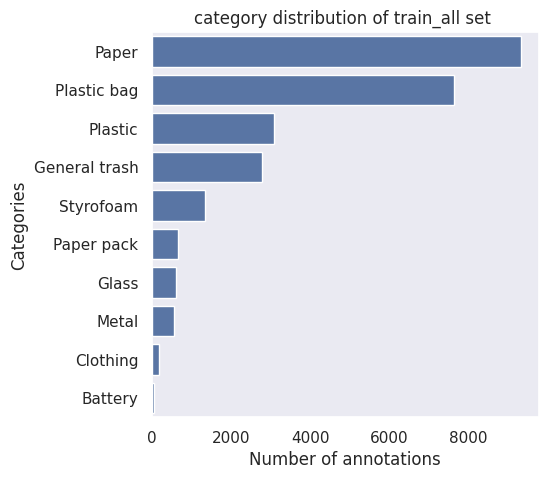

In [5]:
# Count annotations
cat_histogram = np.zeros(nr_cats,dtype=int)
for ann in anns:
    cat_histogram[ann['category_id']-1] += 1

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(5,5))

# Convert to DataFrame
df = pd.DataFrame({'Categories': cat_names, 'Number of annotations': cat_histogram})
df = df.sort_values('Number of annotations', 0, False)

# Plot the histogram
plt.title("category distribution of train_all set ")
plot_1 = sns.barplot(x="Number of annotations", y="Categories", data=df, label="Total", color="b")

In [6]:
# category labeling 
sorted_temp_df = df.sort_index()

# background = 0 에 해당되는 label 추가 후 기존들을 모두 label + 1 로 설정
sorted_df = pd.DataFrame(["Backgroud"], columns = ["Categories"])
sorted_df = sorted_df.append(sorted_temp_df, ignore_index=True)

In [7]:
# class (Categories) 에 따른 index 확인 (0~10 : 총 11개)
sorted_df

Categories  Number of annotations
0       Backgroud                    NaN
1   General trash                 2782.0
2           Paper                 9311.0
3      Paper pack                  659.0
4           Metal                  562.0
5           Glass                  610.0
6         Plastic                 3090.0
7       Styrofoam                 1343.0
8     Plastic bag                 7643.0
9         Battery                   63.0
10       Clothing                  177.0

## 데이터 전처리 함수 정의 (Dataset)

In [8]:
category_names = list(sorted_df.Categories)

def get_classname(classID, cats):
    for i in range(len(cats)):
        if cats[i]['id']==classID:
            return cats[i]['name']
    return "None"

class CustomDataLoader(Dataset):
    """COCO format"""
    def __init__(self, data_dir, mode = 'train', transform = None):
        super().__init__()
        self.mode = mode
        self.transform = transform
        self.coco = COCO(data_dir)
        
    def __getitem__(self, index: int):
        # dataset이 index되어 list처럼 동작
        image_id = self.coco.getImgIds(imgIds=index)
        image_infos = self.coco.loadImgs(image_id)[0]
        
        # cv2 를 활용하여 image 불러오기
        images = cv2.imread(os.path.join(dataset_path, image_infos['file_name']))
        images = cv2.cvtColor(images, cv2.COLOR_BGR2RGB).astype(np.float32)
        images /= 255.0
        
        if (self.mode in ('train', 'val')):
            ann_ids = self.coco.getAnnIds(imgIds=image_infos['id'])
            anns = self.coco.loadAnns(ann_ids)

            # Load the categories in a variable
            cat_ids = self.coco.getCatIds()
            cats = self.coco.loadCats(cat_ids)

            # masks : size가 (height x width)인 2D
            # 각각의 pixel 값에는 "category id" 할당
            # Background = 0
            masks = np.zeros((image_infos["height"], image_infos["width"]))
            # General trash = 1, ... , Cigarette = 10
            anns = sorted(anns, key=lambda idx : idx['area'], reverse=True)
            for i in range(len(anns)):
                className = get_classname(anns[i]['category_id'], cats)
                pixel_value = category_names.index(className)
                masks[self.coco.annToMask(anns[i]) == 1] = pixel_value
            masks = masks.astype(np.int8)
                        
            # transform -> albumentations 라이브러리 활용
            if self.transform is not None:
                transformed = self.transform(image=images, mask=masks)
                images = transformed["image"]
                masks = transformed["mask"]
            return images, masks, image_infos
        
        if self.mode == 'test':
            # transform -> albumentations 라이브러리 활용
            if self.transform is not None:
                transformed = self.transform(image=images)
                images = transformed["image"]
            return images, image_infos
    
    def __len__(self) -> int:
        # 전체 dataset의 size를 return
        return len(self.coco.getImgIds())

## Dataset 정의 및 DataLoader 할당

In [9]:
# train.json / validation.json / test.json 디렉토리 설정
train_path = dataset_path + '/train.json'
val_path = dataset_path + '/val.json'
test_path = dataset_path + '/test.json'

# collate_fn needs for batch
def collate_fn(batch):
    return tuple(zip(*batch))


import albumentations as A
from albumentations.pytorch import ToTensorV2

train_transform = A.Compose([
                            ToTensorV2()
                            ])

val_transform = A.Compose([
                          ToTensorV2()
                          ])

test_transform = A.Compose([
                           ToTensorV2()
                           ])

# create own Dataset 1 (skip)
# validation set을 직접 나누고 싶은 경우
# random_split 사용하여 data set을 8:2 로 분할
# train_size = int(0.8*len(dataset))
# val_size = int(len(dataset)-train_size)
# dataset = CustomDataLoader(data_dir=train_path, mode='train', transform=transform)
# train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# create own Dataset 2
# train dataset
train_dataset = CustomDataLoader(data_dir=train_path, mode='train', transform=train_transform)

# validation dataset
val_dataset = CustomDataLoader(data_dir=val_path, mode='val', transform=val_transform)

# test dataset
test_dataset = CustomDataLoader(data_dir=test_path, mode='test', transform=test_transform)


# DataLoader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size,
                                           shuffle=True,
                                           num_workers=4,
                                           collate_fn=collate_fn)

val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                         batch_size=batch_size,
                                         shuffle=False,
                                         num_workers=4,
                                         collate_fn=collate_fn)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          num_workers=4,
                                          collate_fn=collate_fn)

loading annotations into memory...
Done (t=4.63s)
creating index...
index created!
loading annotations into memory...
Done (t=0.91s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


### 데이터 샘플 시각화 (Show example image and mask)

- `train_loader` 
- `val_loader` 
- `test_loader` 

In [10]:
class_colormap = pd.read_csv("class_dict.csv")
class_colormap

name    r    g    b
0       Backgroud    0    0    0
1   General trash  192    0  128
2           Paper    0  128  192
3      Paper pack    0  128   64
4           Metal  128    0    0
5           Glass   64    0  128
6         Plastic   64    0  192
7       Styrofoam  192  128   64
8     Plastic bag  192  192  128
9         Battery   64   64  128
10       Clothing  128    0  192

In [11]:
def create_trash_label_colormap():
    """Creates a label colormap used in Trash segmentation.
    Returns:
        A colormap for visualizing segmentation results.
    """
    colormap = np.zeros((11, 3), dtype=np.uint8)
    for inex, (_, r, g, b) in enumerate(class_colormap.values):
        colormap[inex] = [r, g, b]
    
    return colormap

def label_to_color_image(label):
    """Adds color defined by the dataset colormap to the label.

    Args:
        label: A 2D array with integer type, storing the segmentation label.

    Returns:
        result: A 2D array with floating type. The element of the array
                is the color indexed by the corresponding element in the input label
                to the trash color map.

    Raises:
        ValueError: If label is not of rank 2 or its value is larger than color
              map maximum entry.
    """
    if label.ndim != 2:
        raise ValueError('Expect 2-D input label')

    colormap = create_trash_label_colormap()

    if np.max(label) >= len(colormap):
        raise ValueError('label value too large.')

    return colormap[label]

image shape: [3, 512, 512]
mask shape:  [512, 512]
Unique values, category of transformed mask : 
 [{0, 'Backgroud'}, {2, 'Paper'}, {8, 'Plastic bag'}]


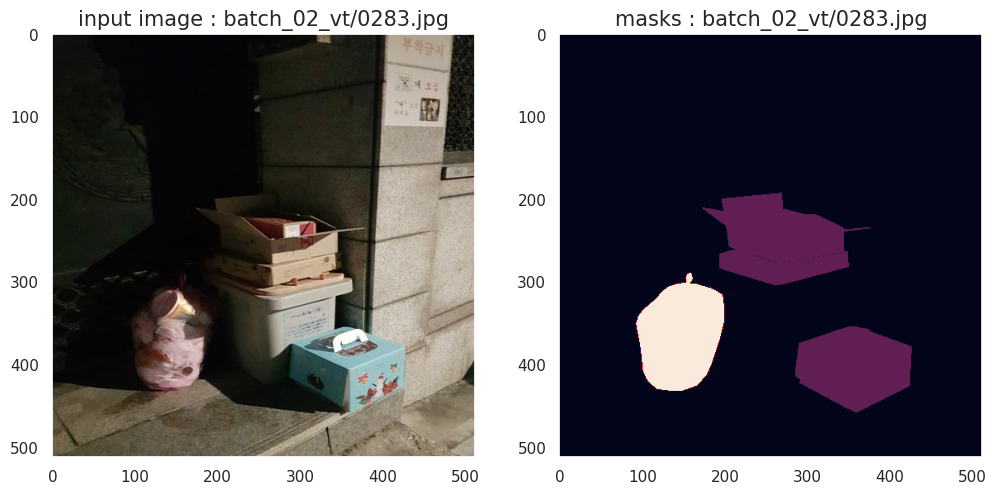

In [12]:
# train_loader의 output 결과(image 및 mask) 확인
for imgs, masks, image_infos in train_loader:
    image_infos = image_infos[0]
    temp_images = imgs
    temp_masks = masks
    break

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 12))

print('image shape:', list(temp_images[0].shape))
print('mask shape: ', list(temp_masks[0].shape))
print('Unique values, category of transformed mask : \n', [{int(i),category_names[int(i)]} for i in list(np.unique(temp_masks[0]))])

ax1.imshow(temp_images[0].permute([1,2,0]))
ax1.grid(False)
ax1.set_title("input image : {}".format(image_infos['file_name']), fontsize = 15)

ax2.imshow(temp_masks[0])
ax2.grid(False)
ax2.set_title("masks : {}".format(image_infos['file_name']), fontsize = 15)

plt.show()

image shape: [3, 512, 512]
mask shape:  [512, 512]
Unique values, category of transformed mask : 
 [{0, 'Backgroud'}, {'Glass', 5}, {'Plastic', 6}, {8, 'Plastic bag'}]


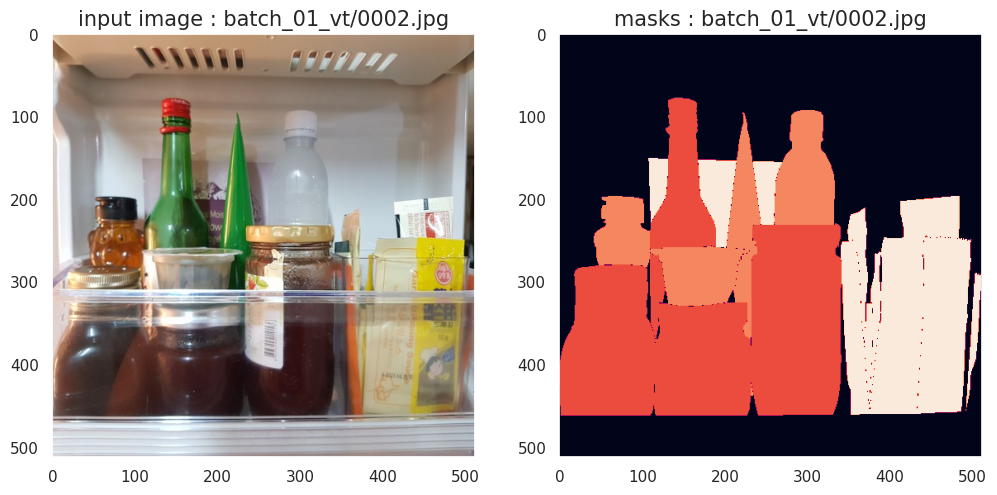

In [13]:
# val_loader의 output 결과(image 및 mask) 확인
for imgs, masks, image_infos in val_loader:
    image_infos = image_infos[0]
    temp_images = imgs
    temp_masks = masks
    
    break

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 12))

print('image shape:', list(temp_images[0].shape))
print('mask shape: ', list(temp_masks[0].shape))

print('Unique values, category of transformed mask : \n', [{int(i),category_names[int(i)]} for i in list(np.unique(temp_masks[0]))])

ax1.imshow(temp_images[0].permute([1,2,0]))
ax1.grid(False)
ax1.set_title("input image : {}".format(image_infos['file_name']), fontsize = 15)

ax2.imshow(temp_masks[0])
ax2.grid(False)
ax2.set_title("masks : {}".format(image_infos['file_name']), fontsize = 15)

plt.show()

image shape: [3, 512, 512]


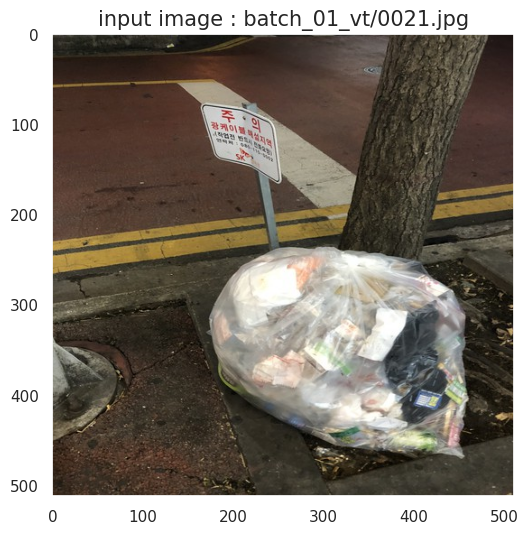

In [14]:
# test_loader의 output 결과(image) 확인
for imgs, image_infos in test_loader:
    image_infos = image_infos[0]
    temp_images = imgs
    
    break

fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))

print('image shape:', list(temp_images[0].shape))

ax1.imshow(temp_images[0].permute([1,2,0]))
ax1.grid(False)
ax1.set_title("input image : {}".format(image_infos['file_name']), fontsize = 15)

plt.show()

## baseline model

### `smp.DeepLabV3Plus()`

In [15]:
# jupyter command 에서 library download 하기
#!pip install git+https://github.com/qubvel/segmentation_models.pytorch

import segmentation_models_pytorch as smp

# model 불러오기
# 출력 label 수 정의 (classes=11)
model = smp.DeepLabV3Plus(
    encoder_name="resnet101", # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=11,                     # model output channels (number of classes in your dataset)
)

In [16]:
# 구현된 model에 임의의 input을 넣어 output이 잘 나오는지 test
x = torch.randn([2, 3, 512, 512])
print(f"input shape : {x.shape}")
out = model(x)
print(f"output shape : {out.size()}")

input shape : torch.Size([2, 3, 512, 512])
output shape : torch.Size([2, 11, 512, 512])


## train, validation, test 함수 정의

In [17]:
def train(num_epochs, model, data_loader, val_loader, criterion, optimizer, saved_dir, val_every, device):
    print(f'Start training..')
    n_class = 11
    best_loss = 9999999
    # wandb.watch(model, criterion, log="all", log_freq=1)
    
    for epoch in range(num_epochs):
        model.train()

        hist = np.zeros((n_class, n_class))
        for step, (images, masks, _) in enumerate(data_loader):
            images = torch.stack(images)       
            masks = torch.stack(masks).long() 
            
            # gpu 연산을 위해 device 할당
            images, masks = images.to(device), masks.to(device)
            
            # device 할당
            model = model.to(device)
            
            # inference
            outputs = model(images)
            
            # loss 계산 (cross entropy loss)
            loss = criterion(outputs, masks)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            outputs = torch.argmax(outputs, dim=1).detach().cpu().numpy()
            masks = masks.detach().cpu().numpy()
            
            hist = add_hist(hist, masks, outputs, n_class=n_class)
            acc, acc_cls, mIoU, fwavacc, IoU = label_accuracy_score(hist)
            
            # step 주기에 따른 loss 출력
            if (step + 1) % 25 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Step [{step+1}/{len(train_loader)}], \
                        Loss: {round(loss.item(),4)}, mIoU: {round(mIoU,4)}')
             
        # validation 주기에 따른 loss 출력 및 best model 저장
        if (epoch + 1) % val_every == 0:
            avrg_loss, val_acc, val_acc_cls, val_mIoU, val_fwavacc, val_IoU = validation(epoch + 1, model, val_loader, criterion, device)
            if avrg_loss < best_loss:
                print(f"Best performance at epoch: {epoch + 1}")
                print(f"Save model in {saved_dir}")
                best_loss = avrg_loss
                save_model(model, saved_dir)
         
        # # wandb logging
        # log_dict = dict()
        # log_dict["acc"] = acc
        # log_dict["acc_cls"] = acc_cls
        # log_dict["mIoU"] = mIoU
        # log_dict["fwavacc"] = fwavacc
        # log_dict["IoU"] = IoU

        # log_dict["val_acc"] = val_acc
        # log_dict["val_acc_cls"] = val_acc_cls
        # log_dict["val_mIoU"] = val_mIoU
        # log_dict["val_fwavacc"] = val_fwavacc
        # log_dict["val_IoU"] = val_IoU

        # wandb.log(log_dict)

In [18]:
def validation(epoch, model, data_loader, criterion, device):
    print(f'Start validation #{epoch}')
    model.eval()

    with torch.no_grad():
        n_class = 11
        total_loss = 0
        cnt = 0
        
        hist = np.zeros((n_class, n_class))
        for step, (images, masks, _) in enumerate(data_loader):
            
            images = torch.stack(images)       
            masks = torch.stack(masks).long()  

            images, masks = images.to(device), masks.to(device)            
            
            # device 할당
            model = model.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, masks)
            total_loss += loss
            cnt += 1
            
            outputs = torch.argmax(outputs, dim=1).detach().cpu().numpy()
            masks = masks.detach().cpu().numpy()
            
            hist = add_hist(hist, masks, outputs, n_class=n_class)
        
        acc, acc_cls, mIoU, fwavacc, IoU = label_accuracy_score(hist)
        IoU_by_class = [{classes : round(IoU,4)} for IoU, classes in zip(IoU , sorted_df['Categories'])]
        
        avrg_loss = total_loss / cnt
        print(f'Validation #{epoch}  Average Loss: {round(avrg_loss.item(), 4)}, Accuracy : {round(acc, 4)}, \
                mIoU: {round(mIoU, 4)}')
        print(f'IoU by class : {IoU_by_class}')
        
    return avrg_loss, acc, acc_cls, mIoU, fwavacc, IoU

## 모델 저장 함수 정의

In [19]:
# 모델 저장 함수 정의
val_every = 1

saved_dir = './saved'
if not os.path.isdir(saved_dir):                                                           
    os.mkdir(saved_dir)

def save_model(model, saved_dir, file_name='efficient_unet_best_model.pt'):
    check_point = {'net': model.state_dict()}
    output_path = os.path.join(saved_dir, file_name)
    torch.save(model, output_path)

## 모델 생성 및 Loss function, Optimizer 정의

In [20]:
# Loss function 정의
criterion = nn.CrossEntropyLoss()

# Optimizer 정의
optimizer = torch.optim.Adam(params = model.parameters(), lr = learning_rate, weight_decay=1e-6)

In [33]:
# wandb.init(project="SH_find_model", entity="boostcamp_aitech4_jdp", name="baseline_efficientb7_unet")
# cfg = {
#     "learning_rate": learning_rate,
#     "epochs": num_epochs,
#     "batch_size": batch_size
# }
# wandb.config.update(cfg)

train(num_epochs, model, train_loader, val_loader, criterion, optimizer, saved_dir, val_every, device)

Start training..
Epoch [1/50], Step [25/374],                         Loss: 1.3268, mIoU: 0.1387
Epoch [1/50], Step [50/374],                         Loss: 1.2068, mIoU: 0.1608
Epoch [1/50], Step [75/374],                         Loss: 0.7658, mIoU: 0.1726
Epoch [1/50], Step [100/374],                         Loss: 0.9634, mIoU: 0.1816
Epoch [1/50], Step [125/374],                         Loss: 1.1086, mIoU: 0.1861
Epoch [1/50], Step [150/374],                         Loss: 0.5632, mIoU: 0.1889
Epoch [1/50], Step [175/374],                         Loss: 0.5581, mIoU: 0.1927
Epoch [1/50], Step [200/374],                         Loss: 0.958, mIoU: 0.2001
Epoch [1/50], Step [225/374],                         Loss: 0.3769, mIoU: 0.2048
Epoch [1/50], Step [250/374],                         Loss: 0.4298, mIoU: 0.2104
Epoch [1/50], Step [275/374],                         Loss: 0.6675, mIoU: 0.2137
Epoch [1/50], Step [300/374],                         Loss: 0.4989, mIoU: 0.219
Epoch [1/50], St

## 저장된 model 불러오기 (학습된 이후) 

In [23]:
# best model 저장된 경로
model_path = './saved/efficient_unet_best_model.pt'

# best model 불러오기
checkpoint = torch.load(model_path, map_location=device)
print(type(checkpoint))
state_dict = checkpoint.state_dict()
model.load_state_dict(state_dict)

model = model.to(device)
# 추론을 실행하기 전에는 반드시 설정 (batch normalization, dropout 를 평가 모드로 설정)
# model.eval()

<class 'segmentation_models_pytorch.decoders.unet.model.Unet'>


RuntimeError: Error(s) in loading state_dict for DeepLabV3Plus:
	Missing key(s) in state_dict: "encoder.conv1.weight", "encoder.bn1.weight", "encoder.bn1.bias", "encoder.bn1.running_mean", "encoder.bn1.running_var", "encoder.layer1.0.conv1.weight", "encoder.layer1.0.bn1.weight", "encoder.layer1.0.bn1.bias", "encoder.layer1.0.bn1.running_mean", "encoder.layer1.0.bn1.running_var", "encoder.layer1.0.conv2.weight", "encoder.layer1.0.bn2.weight", "encoder.layer1.0.bn2.bias", "encoder.layer1.0.bn2.running_mean", "encoder.layer1.0.bn2.running_var", "encoder.layer1.0.conv3.weight", "encoder.layer1.0.bn3.weight", "encoder.layer1.0.bn3.bias", "encoder.layer1.0.bn3.running_mean", "encoder.layer1.0.bn3.running_var", "encoder.layer1.0.downsample.0.weight", "encoder.layer1.0.downsample.1.weight", "encoder.layer1.0.downsample.1.bias", "encoder.layer1.0.downsample.1.running_mean", "encoder.layer1.0.downsample.1.running_var", "encoder.layer1.1.conv1.weight", "encoder.layer1.1.bn1.weight", "encoder.layer1.1.bn1.bias", "encoder.layer1.1.bn1.running_mean", "encoder.layer1.1.bn1.running_var", "encoder.layer1.1.conv2.weight", "encoder.layer1.1.bn2.weight", "encoder.layer1.1.bn2.bias", "encoder.layer1.1.bn2.running_mean", "encoder.layer1.1.bn2.running_var", "encoder.layer1.1.conv3.weight", "encoder.layer1.1.bn3.weight", "encoder.layer1.1.bn3.bias", "encoder.layer1.1.bn3.running_mean", "encoder.layer1.1.bn3.running_var", "encoder.layer1.2.conv1.weight", "encoder.layer1.2.bn1.weight", "encoder.layer1.2.bn1.bias", "encoder.layer1.2.bn1.running_mean", "encoder.layer1.2.bn1.running_var", "encoder.layer1.2.conv2.weight", "encoder.layer1.2.bn2.weight", "encoder.layer1.2.bn2.bias", "encoder.layer1.2.bn2.running_mean", "encoder.layer1.2.bn2.running_var", "encoder.layer1.2.conv3.weight", "encoder.layer1.2.bn3.weight", "encoder.layer1.2.bn3.bias", "encoder.layer1.2.bn3.running_mean", "encoder.layer1.2.bn3.running_var", "encoder.layer2.0.conv1.weight", "encoder.layer2.0.bn1.weight", "encoder.layer2.0.bn1.bias", "encoder.layer2.0.bn1.running_mean", "encoder.layer2.0.bn1.running_var", "encoder.layer2.0.conv2.weight", "encoder.layer2.0.bn2.weight", "encoder.layer2.0.bn2.bias", "encoder.layer2.0.bn2.running_mean", "encoder.layer2.0.bn2.running_var", "encoder.layer2.0.conv3.weight", "encoder.layer2.0.bn3.weight", "encoder.layer2.0.bn3.bias", "encoder.layer2.0.bn3.running_mean", "encoder.layer2.0.bn3.running_var", "encoder.layer2.0.downsample.0.weight", "encoder.layer2.0.downsample.1.weight", "encoder.layer2.0.downsample.1.bias", "encoder.layer2.0.downsample.1.running_mean", "encoder.layer2.0.downsample.1.running_var", "encoder.layer2.1.conv1.weight", "encoder.layer2.1.bn1.weight", "encoder.layer2.1.bn1.bias", "encoder.layer2.1.bn1.running_mean", "encoder.layer2.1.bn1.running_var", "encoder.layer2.1.conv2.weight", "encoder.layer2.1.bn2.weight", "encoder.layer2.1.bn2.bias", "encoder.layer2.1.bn2.running_mean", "encoder.layer2.1.bn2.running_var", "encoder.layer2.1.conv3.weight", "encoder.layer2.1.bn3.weight", "encoder.layer2.1.bn3.bias", "encoder.layer2.1.bn3.running_mean", "encoder.layer2.1.bn3.running_var", "encoder.layer2.2.conv1.weight", "encoder.layer2.2.bn1.weight", "encoder.layer2.2.bn1.bias", "encoder.layer2.2.bn1.running_mean", "encoder.layer2.2.bn1.running_var", "encoder.layer2.2.conv2.weight", "encoder.layer2.2.bn2.weight", "encoder.layer2.2.bn2.bias", "encoder.layer2.2.bn2.running_mean", "encoder.layer2.2.bn2.running_var", "encoder.layer2.2.conv3.weight", "encoder.layer2.2.bn3.weight", "encoder.layer2.2.bn3.bias", "encoder.layer2.2.bn3.running_mean", "encoder.layer2.2.bn3.running_var", "encoder.layer2.3.conv1.weight", "encoder.layer2.3.bn1.weight", "encoder.layer2.3.bn1.bias", "encoder.layer2.3.bn1.running_mean", "encoder.layer2.3.bn1.running_var", "encoder.layer2.3.conv2.weight", "encoder.layer2.3.bn2.weight", "encoder.layer2.3.bn2.bias", "encoder.layer2.3.bn2.running_mean", "encoder.layer2.3.bn2.running_var", "encoder.layer2.3.conv3.weight", "encoder.layer2.3.bn3.weight", "encoder.layer2.3.bn3.bias", "encoder.layer2.3.bn3.running_mean", "encoder.layer2.3.bn3.running_var", "encoder.layer3.0.conv1.weight", "encoder.layer3.0.bn1.weight", "encoder.layer3.0.bn1.bias", "encoder.layer3.0.bn1.running_mean", "encoder.layer3.0.bn1.running_var", "encoder.layer3.0.conv2.weight", "encoder.layer3.0.bn2.weight", "encoder.layer3.0.bn2.bias", "encoder.layer3.0.bn2.running_mean", "encoder.layer3.0.bn2.running_var", "encoder.layer3.0.conv3.weight", "encoder.layer3.0.bn3.weight", "encoder.layer3.0.bn3.bias", "encoder.layer3.0.bn3.running_mean", "encoder.layer3.0.bn3.running_var", "encoder.layer3.0.downsample.0.weight", "encoder.layer3.0.downsample.1.weight", "encoder.layer3.0.downsample.1.bias", "encoder.layer3.0.downsample.1.running_mean", "encoder.layer3.0.downsample.1.running_var", "encoder.layer3.1.conv1.weight", "encoder.layer3.1.bn1.weight", "encoder.layer3.1.bn1.bias", "encoder.layer3.1.bn1.running_mean", "encoder.layer3.1.bn1.running_var", "encoder.layer3.1.conv2.weight", "encoder.layer3.1.bn2.weight", "encoder.layer3.1.bn2.bias", "encoder.layer3.1.bn2.running_mean", "encoder.layer3.1.bn2.running_var", "encoder.layer3.1.conv3.weight", "encoder.layer3.1.bn3.weight", "encoder.layer3.1.bn3.bias", "encoder.layer3.1.bn3.running_mean", "encoder.layer3.1.bn3.running_var", "encoder.layer3.2.conv1.weight", "encoder.layer3.2.bn1.weight", "encoder.layer3.2.bn1.bias", "encoder.layer3.2.bn1.running_mean", "encoder.layer3.2.bn1.running_var", "encoder.layer3.2.conv2.weight", "encoder.layer3.2.bn2.weight", "encoder.layer3.2.bn2.bias", "encoder.layer3.2.bn2.running_mean", "encoder.layer3.2.bn2.running_var", "encoder.layer3.2.conv3.weight", "encoder.layer3.2.bn3.weight", "encoder.layer3.2.bn3.bias", "encoder.layer3.2.bn3.running_mean", "encoder.layer3.2.bn3.running_var", "encoder.layer3.3.conv1.weight", "encoder.layer3.3.bn1.weight", "encoder.layer3.3.bn1.bias", "encoder.layer3.3.bn1.running_mean", "encoder.layer3.3.bn1.running_var", "encoder.layer3.3.conv2.weight", "encoder.layer3.3.bn2.weight", "encoder.layer3.3.bn2.bias", "encoder.layer3.3.bn2.running_mean", "encoder.layer3.3.bn2.running_var", "encoder.layer3.3.conv3.weight", "encoder.layer3.3.bn3.weight", "encoder.layer3.3.bn3.bias", "encoder.layer3.3.bn3.running_mean", "encoder.layer3.3.bn3.running_var", "encoder.layer3.4.conv1.weight", "encoder.layer3.4.bn1.weight", "encoder.layer3.4.bn1.bias", "encoder.layer3.4.bn1.running_mean", "encoder.layer3.4.bn1.running_var", "encoder.layer3.4.conv2.weight", "encoder.layer3.4.bn2.weight", "encoder.layer3.4.bn2.bias", "encoder.layer3.4.bn2.running_mean", "encoder.layer3.4.bn2.running_var", "encoder.layer3.4.conv3.weight", "encoder.layer3.4.bn3.weight", "encoder.layer3.4.bn3.bias", "encoder.layer3.4.bn3.running_mean", "encoder.layer3.4.bn3.running_var", "encoder.layer3.5.conv1.weight", "encoder.layer3.5.bn1.weight", "encoder.layer3.5.bn1.bias", "encoder.layer3.5.bn1.running_mean", "encoder.layer3.5.bn1.running_var", "encoder.layer3.5.conv2.weight", "encoder.layer3.5.bn2.weight", "encoder.layer3.5.bn2.bias", "encoder.layer3.5.bn2.running_mean", "encoder.layer3.5.bn2.running_var", "encoder.layer3.5.conv3.weight", "encoder.layer3.5.bn3.weight", "encoder.layer3.5.bn3.bias", "encoder.layer3.5.bn3.running_mean", "encoder.layer3.5.bn3.running_var", "encoder.layer3.6.conv1.weight", "encoder.layer3.6.bn1.weight", "encoder.layer3.6.bn1.bias", "encoder.layer3.6.bn1.running_mean", "encoder.layer3.6.bn1.running_var", "encoder.layer3.6.conv2.weight", "encoder.layer3.6.bn2.weight", "encoder.layer3.6.bn2.bias", "encoder.layer3.6.bn2.running_mean", "encoder.layer3.6.bn2.running_var", "encoder.layer3.6.conv3.weight", "encoder.layer3.6.bn3.weight", "encoder.layer3.6.bn3.bias", "encoder.layer3.6.bn3.running_mean", "encoder.layer3.6.bn3.running_var", "encoder.layer3.7.conv1.weight", "encoder.layer3.7.bn1.weight", "encoder.layer3.7.bn1.bias", "encoder.layer3.7.bn1.running_mean", "encoder.layer3.7.bn1.running_var", "encoder.layer3.7.conv2.weight", "encoder.layer3.7.bn2.weight", "encoder.layer3.7.bn2.bias", "encoder.layer3.7.bn2.running_mean", "encoder.layer3.7.bn2.running_var", "encoder.layer3.7.conv3.weight", "encoder.layer3.7.bn3.weight", "encoder.layer3.7.bn3.bias", "encoder.layer3.7.bn3.running_mean", "encoder.layer3.7.bn3.running_var", "encoder.layer3.8.conv1.weight", "encoder.layer3.8.bn1.weight", "encoder.layer3.8.bn1.bias", "encoder.layer3.8.bn1.running_mean", "encoder.layer3.8.bn1.running_var", "encoder.layer3.8.conv2.weight", "encoder.layer3.8.bn2.weight", "encoder.layer3.8.bn2.bias", "encoder.layer3.8.bn2.running_mean", "encoder.layer3.8.bn2.running_var", "encoder.layer3.8.conv3.weight", "encoder.layer3.8.bn3.weight", "encoder.layer3.8.bn3.bias", "encoder.layer3.8.bn3.running_mean", "encoder.layer3.8.bn3.running_var", "encoder.layer3.9.conv1.weight", "encoder.layer3.9.bn1.weight", "encoder.layer3.9.bn1.bias", "encoder.layer3.9.bn1.running_mean", "encoder.layer3.9.bn1.running_var", "encoder.layer3.9.conv2.weight", "encoder.layer3.9.bn2.weight", "encoder.layer3.9.bn2.bias", "encoder.layer3.9.bn2.running_mean", "encoder.layer3.9.bn2.running_var", "encoder.layer3.9.conv3.weight", "encoder.layer3.9.bn3.weight", "encoder.layer3.9.bn3.bias", "encoder.layer3.9.bn3.running_mean", "encoder.layer3.9.bn3.running_var", "encoder.layer3.10.conv1.weight", "encoder.layer3.10.bn1.weight", "encoder.layer3.10.bn1.bias", "encoder.layer3.10.bn1.running_mean", "encoder.layer3.10.bn1.running_var", "encoder.layer3.10.conv2.weight", "encoder.layer3.10.bn2.weight", "encoder.layer3.10.bn2.bias", "encoder.layer3.10.bn2.running_mean", "encoder.layer3.10.bn2.running_var", "encoder.layer3.10.conv3.weight", "encoder.layer3.10.bn3.weight", "encoder.layer3.10.bn3.bias", "encoder.layer3.10.bn3.running_mean", "encoder.layer3.10.bn3.running_var", "encoder.layer3.11.conv1.weight", "encoder.layer3.11.bn1.weight", "encoder.layer3.11.bn1.bias", "encoder.layer3.11.bn1.running_mean", "encoder.layer3.11.bn1.running_var", "encoder.layer3.11.conv2.weight", "encoder.layer3.11.bn2.weight", "encoder.layer3.11.bn2.bias", "encoder.layer3.11.bn2.running_mean", "encoder.layer3.11.bn2.running_var", "encoder.layer3.11.conv3.weight", "encoder.layer3.11.bn3.weight", "encoder.layer3.11.bn3.bias", "encoder.layer3.11.bn3.running_mean", "encoder.layer3.11.bn3.running_var", "encoder.layer3.12.conv1.weight", "encoder.layer3.12.bn1.weight", "encoder.layer3.12.bn1.bias", "encoder.layer3.12.bn1.running_mean", "encoder.layer3.12.bn1.running_var", "encoder.layer3.12.conv2.weight", "encoder.layer3.12.bn2.weight", "encoder.layer3.12.bn2.bias", "encoder.layer3.12.bn2.running_mean", "encoder.layer3.12.bn2.running_var", "encoder.layer3.12.conv3.weight", "encoder.layer3.12.bn3.weight", "encoder.layer3.12.bn3.bias", "encoder.layer3.12.bn3.running_mean", "encoder.layer3.12.bn3.running_var", "encoder.layer3.13.conv1.weight", "encoder.layer3.13.bn1.weight", "encoder.layer3.13.bn1.bias", "encoder.layer3.13.bn1.running_mean", "encoder.layer3.13.bn1.running_var", "encoder.layer3.13.conv2.weight", "encoder.layer3.13.bn2.weight", "encoder.layer3.13.bn2.bias", "encoder.layer3.13.bn2.running_mean", "encoder.layer3.13.bn2.running_var", "encoder.layer3.13.conv3.weight", "encoder.layer3.13.bn3.weight", "encoder.layer3.13.bn3.bias", "encoder.layer3.13.bn3.running_mean", "encoder.layer3.13.bn3.running_var", "encoder.layer3.14.conv1.weight", "encoder.layer3.14.bn1.weight", "encoder.layer3.14.bn1.bias", "encoder.layer3.14.bn1.running_mean", "encoder.layer3.14.bn1.running_var", "encoder.layer3.14.conv2.weight", "encoder.layer3.14.bn2.weight", "encoder.layer3.14.bn2.bias", "encoder.layer3.14.bn2.running_mean", "encoder.layer3.14.bn2.running_var", "encoder.layer3.14.conv3.weight", "encoder.layer3.14.bn3.weight", "encoder.layer3.14.bn3.bias", "encoder.layer3.14.bn3.running_mean", "encoder.layer3.14.bn3.running_var", "encoder.layer3.15.conv1.weight", "encoder.layer3.15.bn1.weight", "encoder.layer3.15.bn1.bias", "encoder.layer3.15.bn1.running_mean", "encoder.layer3.15.bn1.running_var", "encoder.layer3.15.conv2.weight", "encoder.layer3.15.bn2.weight", "encoder.layer3.15.bn2.bias", "encoder.layer3.15.bn2.running_mean", "encoder.layer3.15.bn2.running_var", "encoder.layer3.15.conv3.weight", "encoder.layer3.15.bn3.weight", "encoder.layer3.15.bn3.bias", "encoder.layer3.15.bn3.running_mean", "encoder.layer3.15.bn3.running_var", "encoder.layer3.16.conv1.weight", "encoder.layer3.16.bn1.weight", "encoder.layer3.16.bn1.bias", "encoder.layer3.16.bn1.running_mean", "encoder.layer3.16.bn1.running_var", "encoder.layer3.16.conv2.weight", "encoder.layer3.16.bn2.weight", "encoder.layer3.16.bn2.bias", "encoder.layer3.16.bn2.running_mean", "encoder.layer3.16.bn2.running_var", "encoder.layer3.16.conv3.weight", "encoder.layer3.16.bn3.weight", "encoder.layer3.16.bn3.bias", "encoder.layer3.16.bn3.running_mean", "encoder.layer3.16.bn3.running_var", "encoder.layer3.17.conv1.weight", "encoder.layer3.17.bn1.weight", "encoder.layer3.17.bn1.bias", "encoder.layer3.17.bn1.running_mean", "encoder.layer3.17.bn1.running_var", "encoder.layer3.17.conv2.weight", "encoder.layer3.17.bn2.weight", "encoder.layer3.17.bn2.bias", "encoder.layer3.17.bn2.running_mean", "encoder.layer3.17.bn2.running_var", "encoder.layer3.17.conv3.weight", "encoder.layer3.17.bn3.weight", "encoder.layer3.17.bn3.bias", "encoder.layer3.17.bn3.running_mean", "encoder.layer3.17.bn3.running_var", "encoder.layer3.18.conv1.weight", "encoder.layer3.18.bn1.weight", "encoder.layer3.18.bn1.bias", "encoder.layer3.18.bn1.running_mean", "encoder.layer3.18.bn1.running_var", "encoder.layer3.18.conv2.weight", "encoder.layer3.18.bn2.weight", "encoder.layer3.18.bn2.bias", "encoder.layer3.18.bn2.running_mean", "encoder.layer3.18.bn2.running_var", "encoder.layer3.18.conv3.weight", "encoder.layer3.18.bn3.weight", "encoder.layer3.18.bn3.bias", "encoder.layer3.18.bn3.running_mean", "encoder.layer3.18.bn3.running_var", "encoder.layer3.19.conv1.weight", "encoder.layer3.19.bn1.weight", "encoder.layer3.19.bn1.bias", "encoder.layer3.19.bn1.running_mean", "encoder.layer3.19.bn1.running_var", "encoder.layer3.19.conv2.weight", "encoder.layer3.19.bn2.weight", "encoder.layer3.19.bn2.bias", "encoder.layer3.19.bn2.running_mean", "encoder.layer3.19.bn2.running_var", "encoder.layer3.19.conv3.weight", "encoder.layer3.19.bn3.weight", "encoder.layer3.19.bn3.bias", "encoder.layer3.19.bn3.running_mean", "encoder.layer3.19.bn3.running_var", "encoder.layer3.20.conv1.weight", "encoder.layer3.20.bn1.weight", "encoder.layer3.20.bn1.bias", "encoder.layer3.20.bn1.running_mean", "encoder.layer3.20.bn1.running_var", "encoder.layer3.20.conv2.weight", "encoder.layer3.20.bn2.weight", "encoder.layer3.20.bn2.bias", "encoder.layer3.20.bn2.running_mean", "encoder.layer3.20.bn2.running_var", "encoder.layer3.20.conv3.weight", "encoder.layer3.20.bn3.weight", "encoder.layer3.20.bn3.bias", "encoder.layer3.20.bn3.running_mean", "encoder.layer3.20.bn3.running_var", "encoder.layer3.21.conv1.weight", "encoder.layer3.21.bn1.weight", "encoder.layer3.21.bn1.bias", "encoder.layer3.21.bn1.running_mean", "encoder.layer3.21.bn1.running_var", "encoder.layer3.21.conv2.weight", "encoder.layer3.21.bn2.weight", "encoder.layer3.21.bn2.bias", "encoder.layer3.21.bn2.running_mean", "encoder.layer3.21.bn2.running_var", "encoder.layer3.21.conv3.weight", "encoder.layer3.21.bn3.weight", "encoder.layer3.21.bn3.bias", "encoder.layer3.21.bn3.running_mean", "encoder.layer3.21.bn3.running_var", "encoder.layer3.22.conv1.weight", "encoder.layer3.22.bn1.weight", "encoder.layer3.22.bn1.bias", "encoder.layer3.22.bn1.running_mean", "encoder.layer3.22.bn1.running_var", "encoder.layer3.22.conv2.weight", "encoder.layer3.22.bn2.weight", "encoder.layer3.22.bn2.bias", "encoder.layer3.22.bn2.running_mean", "encoder.layer3.22.bn2.running_var", "encoder.layer3.22.conv3.weight", "encoder.layer3.22.bn3.weight", "encoder.layer3.22.bn3.bias", "encoder.layer3.22.bn3.running_mean", "encoder.layer3.22.bn3.running_var", "encoder.layer4.0.conv1.weight", "encoder.layer4.0.bn1.weight", "encoder.layer4.0.bn1.bias", "encoder.layer4.0.bn1.running_mean", "encoder.layer4.0.bn1.running_var", "encoder.layer4.0.conv2.weight", "encoder.layer4.0.bn2.weight", "encoder.layer4.0.bn2.bias", "encoder.layer4.0.bn2.running_mean", "encoder.layer4.0.bn2.running_var", "encoder.layer4.0.conv3.weight", "encoder.layer4.0.bn3.weight", "encoder.layer4.0.bn3.bias", "encoder.layer4.0.bn3.running_mean", "encoder.layer4.0.bn3.running_var", "encoder.layer4.0.downsample.0.weight", "encoder.layer4.0.downsample.1.weight", "encoder.layer4.0.downsample.1.bias", "encoder.layer4.0.downsample.1.running_mean", "encoder.layer4.0.downsample.1.running_var", "encoder.layer4.1.conv1.weight", "encoder.layer4.1.bn1.weight", "encoder.layer4.1.bn1.bias", "encoder.layer4.1.bn1.running_mean", "encoder.layer4.1.bn1.running_var", "encoder.layer4.1.conv2.weight", "encoder.layer4.1.bn2.weight", "encoder.layer4.1.bn2.bias", "encoder.layer4.1.bn2.running_mean", "encoder.layer4.1.bn2.running_var", "encoder.layer4.1.conv3.weight", "encoder.layer4.1.bn3.weight", "encoder.layer4.1.bn3.bias", "encoder.layer4.1.bn3.running_mean", "encoder.layer4.1.bn3.running_var", "encoder.layer4.2.conv1.weight", "encoder.layer4.2.bn1.weight", "encoder.layer4.2.bn1.bias", "encoder.layer4.2.bn1.running_mean", "encoder.layer4.2.bn1.running_var", "encoder.layer4.2.conv2.weight", "encoder.layer4.2.bn2.weight", "encoder.layer4.2.bn2.bias", "encoder.layer4.2.bn2.running_mean", "encoder.layer4.2.bn2.running_var", "encoder.layer4.2.conv3.weight", "encoder.layer4.2.bn3.weight", "encoder.layer4.2.bn3.bias", "encoder.layer4.2.bn3.running_mean", "encoder.layer4.2.bn3.running_var", "decoder.aspp.0.convs.0.0.weight", "decoder.aspp.0.convs.0.1.weight", "decoder.aspp.0.convs.0.1.bias", "decoder.aspp.0.convs.0.1.running_mean", "decoder.aspp.0.convs.0.1.running_var", "decoder.aspp.0.convs.1.0.0.weight", "decoder.aspp.0.convs.1.0.1.weight", "decoder.aspp.0.convs.1.1.weight", "decoder.aspp.0.convs.1.1.bias", "decoder.aspp.0.convs.1.1.running_mean", "decoder.aspp.0.convs.1.1.running_var", "decoder.aspp.0.convs.2.0.0.weight", "decoder.aspp.0.convs.2.0.1.weight", "decoder.aspp.0.convs.2.1.weight", "decoder.aspp.0.convs.2.1.bias", "decoder.aspp.0.convs.2.1.running_mean", "decoder.aspp.0.convs.2.1.running_var", "decoder.aspp.0.convs.3.0.0.weight", "decoder.aspp.0.convs.3.0.1.weight", "decoder.aspp.0.convs.3.1.weight", "decoder.aspp.0.convs.3.1.bias", "decoder.aspp.0.convs.3.1.running_mean", "decoder.aspp.0.convs.3.1.running_var", "decoder.aspp.0.convs.4.1.weight", "decoder.aspp.0.convs.4.2.weight", "decoder.aspp.0.convs.4.2.bias", "decoder.aspp.0.convs.4.2.running_mean", "decoder.aspp.0.convs.4.2.running_var", "decoder.aspp.0.project.0.weight", "decoder.aspp.0.project.1.weight", "decoder.aspp.0.project.1.bias", "decoder.aspp.0.project.1.running_mean", "decoder.aspp.0.project.1.running_var", "decoder.aspp.1.0.weight", "decoder.aspp.1.1.weight", "decoder.aspp.2.weight", "decoder.aspp.2.bias", "decoder.aspp.2.running_mean", "decoder.aspp.2.running_var", "decoder.block1.0.weight", "decoder.block1.1.weight", "decoder.block1.1.bias", "decoder.block1.1.running_mean", "decoder.block1.1.running_var", "decoder.block2.0.0.weight", "decoder.block2.0.1.weight", "decoder.block2.1.weight", "decoder.block2.1.bias", "decoder.block2.1.running_mean", "decoder.block2.1.running_var". 
	Unexpected key(s) in state_dict: "encoder._conv_stem.weight", "encoder._bn0.weight", "encoder._bn0.bias", "encoder._bn0.running_mean", "encoder._bn0.running_var", "encoder._bn0.num_batches_tracked", "encoder._blocks.0._depthwise_conv.weight", "encoder._blocks.0._bn1.weight", "encoder._blocks.0._bn1.bias", "encoder._blocks.0._bn1.running_mean", "encoder._blocks.0._bn1.running_var", "encoder._blocks.0._bn1.num_batches_tracked", "encoder._blocks.0._se_reduce.weight", "encoder._blocks.0._se_reduce.bias", "encoder._blocks.0._se_expand.weight", "encoder._blocks.0._se_expand.bias", "encoder._blocks.0._project_conv.weight", "encoder._blocks.0._bn2.weight", "encoder._blocks.0._bn2.bias", "encoder._blocks.0._bn2.running_mean", "encoder._blocks.0._bn2.running_var", "encoder._blocks.0._bn2.num_batches_tracked", "encoder._blocks.1._depthwise_conv.weight", "encoder._blocks.1._bn1.weight", "encoder._blocks.1._bn1.bias", "encoder._blocks.1._bn1.running_mean", "encoder._blocks.1._bn1.running_var", "encoder._blocks.1._bn1.num_batches_tracked", "encoder._blocks.1._se_reduce.weight", "encoder._blocks.1._se_reduce.bias", "encoder._blocks.1._se_expand.weight", "encoder._blocks.1._se_expand.bias", "encoder._blocks.1._project_conv.weight", "encoder._blocks.1._bn2.weight", "encoder._blocks.1._bn2.bias", "encoder._blocks.1._bn2.running_mean", "encoder._blocks.1._bn2.running_var", "encoder._blocks.1._bn2.num_batches_tracked", "encoder._blocks.2._depthwise_conv.weight", "encoder._blocks.2._bn1.weight", "encoder._blocks.2._bn1.bias", "encoder._blocks.2._bn1.running_mean", "encoder._blocks.2._bn1.running_var", "encoder._blocks.2._bn1.num_batches_tracked", "encoder._blocks.2._se_reduce.weight", "encoder._blocks.2._se_reduce.bias", "encoder._blocks.2._se_expand.weight", "encoder._blocks.2._se_expand.bias", "encoder._blocks.2._project_conv.weight", "encoder._blocks.2._bn2.weight", "encoder._blocks.2._bn2.bias", "encoder._blocks.2._bn2.running_mean", "encoder._blocks.2._bn2.running_var", "encoder._blocks.2._bn2.num_batches_tracked", "encoder._blocks.3._depthwise_conv.weight", "encoder._blocks.3._bn1.weight", "encoder._blocks.3._bn1.bias", "encoder._blocks.3._bn1.running_mean", "encoder._blocks.3._bn1.running_var", "encoder._blocks.3._bn1.num_batches_tracked", "encoder._blocks.3._se_reduce.weight", "encoder._blocks.3._se_reduce.bias", "encoder._blocks.3._se_expand.weight", "encoder._blocks.3._se_expand.bias", "encoder._blocks.3._project_conv.weight", "encoder._blocks.3._bn2.weight", "encoder._blocks.3._bn2.bias", "encoder._blocks.3._bn2.running_mean", "encoder._blocks.3._bn2.running_var", "encoder._blocks.3._bn2.num_batches_tracked", "encoder._blocks.4._expand_conv.weight", "encoder._blocks.4._bn0.weight", "encoder._blocks.4._bn0.bias", "encoder._blocks.4._bn0.running_mean", "encoder._blocks.4._bn0.running_var", "encoder._blocks.4._bn0.num_batches_tracked", "encoder._blocks.4._depthwise_conv.weight", "encoder._blocks.4._bn1.weight", "encoder._blocks.4._bn1.bias", "encoder._blocks.4._bn1.running_mean", "encoder._blocks.4._bn1.running_var", "encoder._blocks.4._bn1.num_batches_tracked", "encoder._blocks.4._se_reduce.weight", "encoder._blocks.4._se_reduce.bias", "encoder._blocks.4._se_expand.weight", "encoder._blocks.4._se_expand.bias", "encoder._blocks.4._project_conv.weight", "encoder._blocks.4._bn2.weight", "encoder._blocks.4._bn2.bias", "encoder._blocks.4._bn2.running_mean", "encoder._blocks.4._bn2.running_var", "encoder._blocks.4._bn2.num_batches_tracked", "encoder._blocks.5._expand_conv.weight", "encoder._blocks.5._bn0.weight", "encoder._blocks.5._bn0.bias", "encoder._blocks.5._bn0.running_mean", "encoder._blocks.5._bn0.running_var", "encoder._blocks.5._bn0.num_batches_tracked", "encoder._blocks.5._depthwise_conv.weight", "encoder._blocks.5._bn1.weight", "encoder._blocks.5._bn1.bias", "encoder._blocks.5._bn1.running_mean", "encoder._blocks.5._bn1.running_var", "encoder._blocks.5._bn1.num_batches_tracked", "encoder._blocks.5._se_reduce.weight", "encoder._blocks.5._se_reduce.bias", "encoder._blocks.5._se_expand.weight", "encoder._blocks.5._se_expand.bias", "encoder._blocks.5._project_conv.weight", "encoder._blocks.5._bn2.weight", "encoder._blocks.5._bn2.bias", "encoder._blocks.5._bn2.running_mean", "encoder._blocks.5._bn2.running_var", "encoder._blocks.5._bn2.num_batches_tracked", "encoder._blocks.6._expand_conv.weight", "encoder._blocks.6._bn0.weight", "encoder._blocks.6._bn0.bias", "encoder._blocks.6._bn0.running_mean", "encoder._blocks.6._bn0.running_var", "encoder._blocks.6._bn0.num_batches_tracked", "encoder._blocks.6._depthwise_conv.weight", "encoder._blocks.6._bn1.weight", "encoder._blocks.6._bn1.bias", "encoder._blocks.6._bn1.running_mean", "encoder._blocks.6._bn1.running_var", "encoder._blocks.6._bn1.num_batches_tracked", "encoder._blocks.6._se_reduce.weight", "encoder._blocks.6._se_reduce.bias", "encoder._blocks.6._se_expand.weight", "encoder._blocks.6._se_expand.bias", "encoder._blocks.6._project_conv.weight", "encoder._blocks.6._bn2.weight", "encoder._blocks.6._bn2.bias", "encoder._blocks.6._bn2.running_mean", "encoder._blocks.6._bn2.running_var", "encoder._blocks.6._bn2.num_batches_tracked", "encoder._blocks.7._expand_conv.weight", "encoder._blocks.7._bn0.weight", "encoder._blocks.7._bn0.bias", "encoder._blocks.7._bn0.running_mean", "encoder._blocks.7._bn0.running_var", "encoder._blocks.7._bn0.num_batches_tracked", "encoder._blocks.7._depthwise_conv.weight", "encoder._blocks.7._bn1.weight", "encoder._blocks.7._bn1.bias", "encoder._blocks.7._bn1.running_mean", "encoder._blocks.7._bn1.running_var", "encoder._blocks.7._bn1.num_batches_tracked", "encoder._blocks.7._se_reduce.weight", "encoder._blocks.7._se_reduce.bias", "encoder._blocks.7._se_expand.weight", "encoder._blocks.7._se_expand.bias", "encoder._blocks.7._project_conv.weight", "encoder._blocks.7._bn2.weight", "encoder._blocks.7._bn2.bias", "encoder._blocks.7._bn2.running_mean", "encoder._blocks.7._bn2.running_var", "encoder._blocks.7._bn2.num_batches_tracked", "encoder._blocks.8._expand_conv.weight", "encoder._blocks.8._bn0.weight", "encoder._blocks.8._bn0.bias", "encoder._blocks.8._bn0.running_mean", "encoder._blocks.8._bn0.running_var", "encoder._blocks.8._bn0.num_batches_tracked", "encoder._blocks.8._depthwise_conv.weight", "encoder._blocks.8._bn1.weight", "encoder._blocks.8._bn1.bias", "encoder._blocks.8._bn1.running_mean", "encoder._blocks.8._bn1.running_var", "encoder._blocks.8._bn1.num_batches_tracked", "encoder._blocks.8._se_reduce.weight", "encoder._blocks.8._se_reduce.bias", "encoder._blocks.8._se_expand.weight", "encoder._blocks.8._se_expand.bias", "encoder._blocks.8._project_conv.weight", "encoder._blocks.8._bn2.weight", "encoder._blocks.8._bn2.bias", "encoder._blocks.8._bn2.running_mean", "encoder._blocks.8._bn2.running_var", "encoder._blocks.8._bn2.num_batches_tracked", "encoder._blocks.9._expand_conv.weight", "encoder._blocks.9._bn0.weight", "encoder._blocks.9._bn0.bias", "encoder._blocks.9._bn0.running_mean", "encoder._blocks.9._bn0.running_var", "encoder._blocks.9._bn0.num_batches_tracked", "encoder._blocks.9._depthwise_conv.weight", "encoder._blocks.9._bn1.weight", "encoder._blocks.9._bn1.bias", "encoder._blocks.9._bn1.running_mean", "encoder._blocks.9._bn1.running_var", "encoder._blocks.9._bn1.num_batches_tracked", "encoder._blocks.9._se_reduce.weight", "encoder._blocks.9._se_reduce.bias", "encoder._blocks.9._se_expand.weight", "encoder._blocks.9._se_expand.bias", "encoder._blocks.9._project_conv.weight", "encoder._blocks.9._bn2.weight", "encoder._blocks.9._bn2.bias", "encoder._blocks.9._bn2.running_mean", "encoder._blocks.9._bn2.running_var", "encoder._blocks.9._bn2.num_batches_tracked", "encoder._blocks.10._expand_conv.weight", "encoder._blocks.10._bn0.weight", "encoder._blocks.10._bn0.bias", "encoder._blocks.10._bn0.running_mean", "encoder._blocks.10._bn0.running_var", "encoder._blocks.10._bn0.num_batches_tracked", "encoder._blocks.10._depthwise_conv.weight", "encoder._blocks.10._bn1.weight", "encoder._blocks.10._bn1.bias", "encoder._blocks.10._bn1.running_mean", "encoder._blocks.10._bn1.running_var", "encoder._blocks.10._bn1.num_batches_tracked", "encoder._blocks.10._se_reduce.weight", "encoder._blocks.10._se_reduce.bias", "encoder._blocks.10._se_expand.weight", "encoder._blocks.10._se_expand.bias", "encoder._blocks.10._project_conv.weight", "encoder._blocks.10._bn2.weight", "encoder._blocks.10._bn2.bias", "encoder._blocks.10._bn2.running_mean", "encoder._blocks.10._bn2.running_var", "encoder._blocks.10._bn2.num_batches_tracked", "encoder._blocks.11._expand_conv.weight", "encoder._blocks.11._bn0.weight", "encoder._blocks.11._bn0.bias", "encoder._blocks.11._bn0.running_mean", "encoder._blocks.11._bn0.running_var", "encoder._blocks.11._bn0.num_batches_tracked", "encoder._blocks.11._depthwise_conv.weight", "encoder._blocks.11._bn1.weight", "encoder._blocks.11._bn1.bias", "encoder._blocks.11._bn1.running_mean", "encoder._blocks.11._bn1.running_var", "encoder._blocks.11._bn1.num_batches_tracked", "encoder._blocks.11._se_reduce.weight", "encoder._blocks.11._se_reduce.bias", "encoder._blocks.11._se_expand.weight", "encoder._blocks.11._se_expand.bias", "encoder._blocks.11._project_conv.weight", "encoder._blocks.11._bn2.weight", "encoder._blocks.11._bn2.bias", "encoder._blocks.11._bn2.running_mean", "encoder._blocks.11._bn2.running_var", "encoder._blocks.11._bn2.num_batches_tracked", "encoder._blocks.12._expand_conv.weight", "encoder._blocks.12._bn0.weight", "encoder._blocks.12._bn0.bias", "encoder._blocks.12._bn0.running_mean", "encoder._blocks.12._bn0.running_var", "encoder._blocks.12._bn0.num_batches_tracked", "encoder._blocks.12._depthwise_conv.weight", "encoder._blocks.12._bn1.weight", "encoder._blocks.12._bn1.bias", "encoder._blocks.12._bn1.running_mean", "encoder._blocks.12._bn1.running_var", "encoder._blocks.12._bn1.num_batches_tracked", "encoder._blocks.12._se_reduce.weight", "encoder._blocks.12._se_reduce.bias", "encoder._blocks.12._se_expand.weight", "encoder._blocks.12._se_expand.bias", "encoder._blocks.12._project_conv.weight", "encoder._blocks.12._bn2.weight", "encoder._blocks.12._bn2.bias", "encoder._blocks.12._bn2.running_mean", "encoder._blocks.12._bn2.running_var", "encoder._blocks.12._bn2.num_batches_tracked", "encoder._blocks.13._expand_conv.weight", "encoder._blocks.13._bn0.weight", "encoder._blocks.13._bn0.bias", "encoder._blocks.13._bn0.running_mean", "encoder._blocks.13._bn0.running_var", "encoder._blocks.13._bn0.num_batches_tracked", "encoder._blocks.13._depthwise_conv.weight", "encoder._blocks.13._bn1.weight", "encoder._blocks.13._bn1.bias", "encoder._blocks.13._bn1.running_mean", "encoder._blocks.13._bn1.running_var", "encoder._blocks.13._bn1.num_batches_tracked", "encoder._blocks.13._se_reduce.weight", "encoder._blocks.13._se_reduce.bias", "encoder._blocks.13._se_expand.weight", "encoder._blocks.13._se_expand.bias", "encoder._blocks.13._project_conv.weight", "encoder._blocks.13._bn2.weight", "encoder._blocks.13._bn2.bias", "encoder._blocks.13._bn2.running_mean", "encoder._blocks.13._bn2.running_var", "encoder._blocks.13._bn2.num_batches_tracked", "encoder._blocks.14._expand_conv.weight", "encoder._blocks.14._bn0.weight", "encoder._blocks.14._bn0.bias", "encoder._blocks.14._bn0.running_mean", "encoder._blocks.14._bn0.running_var", "encoder._blocks.14._bn0.num_batches_tracked", "encoder._blocks.14._depthwise_conv.weight", "encoder._blocks.14._bn1.weight", "encoder._blocks.14._bn1.bias", "encoder._blocks.14._bn1.running_mean", "encoder._blocks.14._bn1.running_var", "encoder._blocks.14._bn1.num_batches_tracked", "encoder._blocks.14._se_reduce.weight", "encoder._blocks.14._se_reduce.bias", "encoder._blocks.14._se_expand.weight", "encoder._blocks.14._se_expand.bias", "encoder._blocks.14._project_conv.weight", "encoder._blocks.14._bn2.weight", "encoder._blocks.14._bn2.bias", "encoder._blocks.14._bn2.running_mean", "encoder._blocks.14._bn2.running_var", "encoder._blocks.14._bn2.num_batches_tracked", "encoder._blocks.15._expand_conv.weight", "encoder._blocks.15._bn0.weight", "encoder._blocks.15._bn0.bias", "encoder._blocks.15._bn0.running_mean", "encoder._blocks.15._bn0.running_var", "encoder._blocks.15._bn0.num_batches_tracked", "encoder._blocks.15._depthwise_conv.weight", "encoder._blocks.15._bn1.weight", "encoder._blocks.15._bn1.bias", "encoder._blocks.15._bn1.running_mean", "encoder._blocks.15._bn1.running_var", "encoder._blocks.15._bn1.num_batches_tracked", "encoder._blocks.15._se_reduce.weight", "encoder._blocks.15._se_reduce.bias", "encoder._blocks.15._se_expand.weight", "encoder._blocks.15._se_expand.bias", "encoder._blocks.15._project_conv.weight", "encoder._blocks.15._bn2.weight", "encoder._blocks.15._bn2.bias", "encoder._blocks.15._bn2.running_mean", "encoder._blocks.15._bn2.running_var", "encoder._blocks.15._bn2.num_batches_tracked", "encoder._blocks.16._expand_conv.weight", "encoder._blocks.16._bn0.weight", "encoder._blocks.16._bn0.bias", "encoder._blocks.16._bn0.running_mean", "encoder._blocks.16._bn0.running_var", "encoder._blocks.16._bn0.num_batches_tracked", "encoder._blocks.16._depthwise_conv.weight", "encoder._blocks.16._bn1.weight", "encoder._blocks.16._bn1.bias", "encoder._blocks.16._bn1.running_mean", "encoder._blocks.16._bn1.running_var", "encoder._blocks.16._bn1.num_batches_tracked", "encoder._blocks.16._se_reduce.weight", "encoder._blocks.16._se_reduce.bias", "encoder._blocks.16._se_expand.weight", "encoder._blocks.16._se_expand.bias", "encoder._blocks.16._project_conv.weight", "encoder._blocks.16._bn2.weight", "encoder._blocks.16._bn2.bias", "encoder._blocks.16._bn2.running_mean", "encoder._blocks.16._bn2.running_var", "encoder._blocks.16._bn2.num_batches_tracked", "encoder._blocks.17._expand_conv.weight", "encoder._blocks.17._bn0.weight", "encoder._blocks.17._bn0.bias", "encoder._blocks.17._bn0.running_mean", "encoder._blocks.17._bn0.running_var", "encoder._blocks.17._bn0.num_batches_tracked", "encoder._blocks.17._depthwise_conv.weight", "encoder._blocks.17._bn1.weight", "encoder._blocks.17._bn1.bias", "encoder._blocks.17._bn1.running_mean", "encoder._blocks.17._bn1.running_var", "encoder._blocks.17._bn1.num_batches_tracked", "encoder._blocks.17._se_reduce.weight", "encoder._blocks.17._se_reduce.bias", "encoder._blocks.17._se_expand.weight", "encoder._blocks.17._se_expand.bias", "encoder._blocks.17._project_conv.weight", "encoder._blocks.17._bn2.weight", "encoder._blocks.17._bn2.bias", "encoder._blocks.17._bn2.running_mean", "encoder._blocks.17._bn2.running_var", "encoder._blocks.17._bn2.num_batches_tracked", "encoder._blocks.18._expand_conv.weight", "encoder._blocks.18._bn0.weight", "encoder._blocks.18._bn0.bias", "encoder._blocks.18._bn0.running_mean", "encoder._blocks.18._bn0.running_var", "encoder._blocks.18._bn0.num_batches_tracked", "encoder._blocks.18._depthwise_conv.weight", "encoder._blocks.18._bn1.weight", "encoder._blocks.18._bn1.bias", "encoder._blocks.18._bn1.running_mean", "encoder._blocks.18._bn1.running_var", "encoder._blocks.18._bn1.num_batches_tracked", "encoder._blocks.18._se_reduce.weight", "encoder._blocks.18._se_reduce.bias", "encoder._blocks.18._se_expand.weight", "encoder._blocks.18._se_expand.bias", "encoder._blocks.18._project_conv.weight", "encoder._blocks.18._bn2.weight", "encoder._blocks.18._bn2.bias", "encoder._blocks.18._bn2.running_mean", "encoder._blocks.18._bn2.running_var", "encoder._blocks.18._bn2.num_batches_tracked", "encoder._blocks.19._expand_conv.weight", "encoder._blocks.19._bn0.weight", "encoder._blocks.19._bn0.bias", "encoder._blocks.19._bn0.running_mean", "encoder._blocks.19._bn0.running_var", "encoder._blocks.19._bn0.num_batches_tracked", "encoder._blocks.19._depthwise_conv.weight", "encoder._blocks.19._bn1.weight", "encoder._blocks.19._bn1.bias", "encoder._blocks.19._bn1.running_mean", "encoder._blocks.19._bn1.running_var", "encoder._blocks.19._bn1.num_batches_tracked", "encoder._blocks.19._se_reduce.weight", "encoder._blocks.19._se_reduce.bias", "encoder._blocks.19._se_expand.weight", "encoder._blocks.19._se_expand.bias", "encoder._blocks.19._project_conv.weight", "encoder._blocks.19._bn2.weight", "encoder._blocks.19._bn2.bias", "encoder._blocks.19._bn2.running_mean", "encoder._blocks.19._bn2.running_var", "encoder._blocks.19._bn2.num_batches_tracked", "encoder._blocks.20._expand_conv.weight", "encoder._blocks.20._bn0.weight", "encoder._blocks.20._bn0.bias", "encoder._blocks.20._bn0.running_mean", "encoder._blocks.20._bn0.running_var", "encoder._blocks.20._bn0.num_batches_tracked", "encoder._blocks.20._depthwise_conv.weight", "encoder._blocks.20._bn1.weight", "encoder._blocks.20._bn1.bias", "encoder._blocks.20._bn1.running_mean", "encoder._blocks.20._bn1.running_var", "encoder._blocks.20._bn1.num_batches_tracked", "encoder._blocks.20._se_reduce.weight", "encoder._blocks.20._se_reduce.bias", "encoder._blocks.20._se_expand.weight", "encoder._blocks.20._se_expand.bias", "encoder._blocks.20._project_conv.weight", "encoder._blocks.20._bn2.weight", "encoder._blocks.20._bn2.bias", "encoder._blocks.20._bn2.running_mean", "encoder._blocks.20._bn2.running_var", "encoder._blocks.20._bn2.num_batches_tracked", "encoder._blocks.21._expand_conv.weight", "encoder._blocks.21._bn0.weight", "encoder._blocks.21._bn0.bias", "encoder._blocks.21._bn0.running_mean", "encoder._blocks.21._bn0.running_var", "encoder._blocks.21._bn0.num_batches_tracked", "encoder._blocks.21._depthwise_conv.weight", "encoder._blocks.21._bn1.weight", "encoder._blocks.21._bn1.bias", "encoder._blocks.21._bn1.running_mean", "encoder._blocks.21._bn1.running_var", "encoder._blocks.21._bn1.num_batches_tracked", "encoder._blocks.21._se_reduce.weight", "encoder._blocks.21._se_reduce.bias", "encoder._blocks.21._se_expand.weight", "encoder._blocks.21._se_expand.bias", "encoder._blocks.21._project_conv.weight", "encoder._blocks.21._bn2.weight", "encoder._blocks.21._bn2.bias", "encoder._blocks.21._bn2.running_mean", "encoder._blocks.21._bn2.running_var", "encoder._blocks.21._bn2.num_batches_tracked", "encoder._blocks.22._expand_conv.weight", "encoder._blocks.22._bn0.weight", "encoder._blocks.22._bn0.bias", "encoder._blocks.22._bn0.running_mean", "encoder._blocks.22._bn0.running_var", "encoder._blocks.22._bn0.num_batches_tracked", "encoder._blocks.22._depthwise_conv.weight", "encoder._blocks.22._bn1.weight", "encoder._blocks.22._bn1.bias", "encoder._blocks.22._bn1.running_mean", "encoder._blocks.22._bn1.running_var", "encoder._blocks.22._bn1.num_batches_tracked", "encoder._blocks.22._se_reduce.weight", "encoder._blocks.22._se_reduce.bias", "encoder._blocks.22._se_expand.weight", "encoder._blocks.22._se_expand.bias", "encoder._blocks.22._project_conv.weight", "encoder._blocks.22._bn2.weight", "encoder._blocks.22._bn2.bias", "encoder._blocks.22._bn2.running_mean", "encoder._blocks.22._bn2.running_var", "encoder._blocks.22._bn2.num_batches_tracked", "encoder._blocks.23._expand_conv.weight", "encoder._blocks.23._bn0.weight", "encoder._blocks.23._bn0.bias", "encoder._blocks.23._bn0.running_mean", "encoder._blocks.23._bn0.running_var", "encoder._blocks.23._bn0.num_batches_tracked", "encoder._blocks.23._depthwise_conv.weight", "encoder._blocks.23._bn1.weight", "encoder._blocks.23._bn1.bias", "encoder._blocks.23._bn1.running_mean", "encoder._blocks.23._bn1.running_var", "encoder._blocks.23._bn1.num_batches_tracked", "encoder._blocks.23._se_reduce.weight", "encoder._blocks.23._se_reduce.bias", "encoder._blocks.23._se_expand.weight", "encoder._blocks.23._se_expand.bias", "encoder._blocks.23._project_conv.weight", "encoder._blocks.23._bn2.weight", "encoder._blocks.23._bn2.bias", "encoder._blocks.23._bn2.running_mean", "encoder._blocks.23._bn2.running_var", "encoder._blocks.23._bn2.num_batches_tracked", "encoder._blocks.24._expand_conv.weight", "encoder._blocks.24._bn0.weight", "encoder._blocks.24._bn0.bias", "encoder._blocks.24._bn0.running_mean", "encoder._blocks.24._bn0.running_var", "encoder._blocks.24._bn0.num_batches_tracked", "encoder._blocks.24._depthwise_conv.weight", "encoder._blocks.24._bn1.weight", "encoder._blocks.24._bn1.bias", "encoder._blocks.24._bn1.running_mean", "encoder._blocks.24._bn1.running_var", "encoder._blocks.24._bn1.num_batches_tracked", "encoder._blocks.24._se_reduce.weight", "encoder._blocks.24._se_reduce.bias", "encoder._blocks.24._se_expand.weight", "encoder._blocks.24._se_expand.bias", "encoder._blocks.24._project_conv.weight", "encoder._blocks.24._bn2.weight", "encoder._blocks.24._bn2.bias", "encoder._blocks.24._bn2.running_mean", "encoder._blocks.24._bn2.running_var", "encoder._blocks.24._bn2.num_batches_tracked", "encoder._blocks.25._expand_conv.weight", "encoder._blocks.25._bn0.weight", "encoder._blocks.25._bn0.bias", "encoder._blocks.25._bn0.running_mean", "encoder._blocks.25._bn0.running_var", "encoder._blocks.25._bn0.num_batches_tracked", "encoder._blocks.25._depthwise_conv.weight", "encoder._blocks.25._bn1.weight", "encoder._blocks.25._bn1.bias", "encoder._blocks.25._bn1.running_mean", "encoder._blocks.25._bn1.running_var", "encoder._blocks.25._bn1.num_batches_tracked", "encoder._blocks.25._se_reduce.weight", "encoder._blocks.25._se_reduce.bias", "encoder._blocks.25._se_expand.weight", "encoder._blocks.25._se_expand.bias", "encoder._blocks.25._project_conv.weight", "encoder._blocks.25._bn2.weight", "encoder._blocks.25._bn2.bias", "encoder._blocks.25._bn2.running_mean", "encoder._blocks.25._bn2.running_var", "encoder._blocks.25._bn2.num_batches_tracked", "encoder._blocks.26._expand_conv.weight", "encoder._blocks.26._bn0.weight", "encoder._blocks.26._bn0.bias", "encoder._blocks.26._bn0.running_mean", "encoder._blocks.26._bn0.running_var", "encoder._blocks.26._bn0.num_batches_tracked", "encoder._blocks.26._depthwise_conv.weight", "encoder._blocks.26._bn1.weight", "encoder._blocks.26._bn1.bias", "encoder._blocks.26._bn1.running_mean", "encoder._blocks.26._bn1.running_var", "encoder._blocks.26._bn1.num_batches_tracked", "encoder._blocks.26._se_reduce.weight", "encoder._blocks.26._se_reduce.bias", "encoder._blocks.26._se_expand.weight", "encoder._blocks.26._se_expand.bias", "encoder._blocks.26._project_conv.weight", "encoder._blocks.26._bn2.weight", "encoder._blocks.26._bn2.bias", "encoder._blocks.26._bn2.running_mean", "encoder._blocks.26._bn2.running_var", "encoder._blocks.26._bn2.num_batches_tracked", "encoder._blocks.27._expand_conv.weight", "encoder._blocks.27._bn0.weight", "encoder._blocks.27._bn0.bias", "encoder._blocks.27._bn0.running_mean", "encoder._blocks.27._bn0.running_var", "encoder._blocks.27._bn0.num_batches_tracked", "encoder._blocks.27._depthwise_conv.weight", "encoder._blocks.27._bn1.weight", "encoder._blocks.27._bn1.bias", "encoder._blocks.27._bn1.running_mean", "encoder._blocks.27._bn1.running_var", "encoder._blocks.27._bn1.num_batches_tracked", "encoder._blocks.27._se_reduce.weight", "encoder._blocks.27._se_reduce.bias", "encoder._blocks.27._se_expand.weight", "encoder._blocks.27._se_expand.bias", "encoder._blocks.27._project_conv.weight", "encoder._blocks.27._bn2.weight", "encoder._blocks.27._bn2.bias", "encoder._blocks.27._bn2.running_mean", "encoder._blocks.27._bn2.running_var", "encoder._blocks.27._bn2.num_batches_tracked", "encoder._blocks.28._expand_conv.weight", "encoder._blocks.28._bn0.weight", "encoder._blocks.28._bn0.bias", "encoder._blocks.28._bn0.running_mean", "encoder._blocks.28._bn0.running_var", "encoder._blocks.28._bn0.num_batches_tracked", "encoder._blocks.28._depthwise_conv.weight", "encoder._blocks.28._bn1.weight", "encoder._blocks.28._bn1.bias", "encoder._blocks.28._bn1.running_mean", "encoder._blocks.28._bn1.running_var", "encoder._blocks.28._bn1.num_batches_tracked", "encoder._blocks.28._se_reduce.weight", "encoder._blocks.28._se_reduce.bias", "encoder._blocks.28._se_expand.weight", "encoder._blocks.28._se_expand.bias", "encoder._blocks.28._project_conv.weight", "encoder._blocks.28._bn2.weight", "encoder._blocks.28._bn2.bias", "encoder._blocks.28._bn2.running_mean", "encoder._blocks.28._bn2.running_var", "encoder._blocks.28._bn2.num_batches_tracked", "encoder._blocks.29._expand_conv.weight", "encoder._blocks.29._bn0.weight", "encoder._blocks.29._bn0.bias", "encoder._blocks.29._bn0.running_mean", "encoder._blocks.29._bn0.running_var", "encoder._blocks.29._bn0.num_batches_tracked", "encoder._blocks.29._depthwise_conv.weight", "encoder._blocks.29._bn1.weight", "encoder._blocks.29._bn1.bias", "encoder._blocks.29._bn1.running_mean", "encoder._blocks.29._bn1.running_var", "encoder._blocks.29._bn1.num_batches_tracked", "encoder._blocks.29._se_reduce.weight", "encoder._blocks.29._se_reduce.bias", "encoder._blocks.29._se_expand.weight", "encoder._blocks.29._se_expand.bias", "encoder._blocks.29._project_conv.weight", "encoder._blocks.29._bn2.weight", "encoder._blocks.29._bn2.bias", "encoder._blocks.29._bn2.running_mean", "encoder._blocks.29._bn2.running_var", "encoder._blocks.29._bn2.num_batches_tracked", "encoder._blocks.30._expand_conv.weight", "encoder._blocks.30._bn0.weight", "encoder._blocks.30._bn0.bias", "encoder._blocks.30._bn0.running_mean", "encoder._blocks.30._bn0.running_var", "encoder._blocks.30._bn0.num_batches_tracked", "encoder._blocks.30._depthwise_conv.weight", "encoder._blocks.30._bn1.weight", "encoder._blocks.30._bn1.bias", "encoder._blocks.30._bn1.running_mean", "encoder._blocks.30._bn1.running_var", "encoder._blocks.30._bn1.num_batches_tracked", "encoder._blocks.30._se_reduce.weight", "encoder._blocks.30._se_reduce.bias", "encoder._blocks.30._se_expand.weight", "encoder._blocks.30._se_expand.bias", "encoder._blocks.30._project_conv.weight", "encoder._blocks.30._bn2.weight", "encoder._blocks.30._bn2.bias", "encoder._blocks.30._bn2.running_mean", "encoder._blocks.30._bn2.running_var", "encoder._blocks.30._bn2.num_batches_tracked", "encoder._blocks.31._expand_conv.weight", "encoder._blocks.31._bn0.weight", "encoder._blocks.31._bn0.bias", "encoder._blocks.31._bn0.running_mean", "encoder._blocks.31._bn0.running_var", "encoder._blocks.31._bn0.num_batches_tracked", "encoder._blocks.31._depthwise_conv.weight", "encoder._blocks.31._bn1.weight", "encoder._blocks.31._bn1.bias", "encoder._blocks.31._bn1.running_mean", "encoder._blocks.31._bn1.running_var", "encoder._blocks.31._bn1.num_batches_tracked", "encoder._blocks.31._se_reduce.weight", "encoder._blocks.31._se_reduce.bias", "encoder._blocks.31._se_expand.weight", "encoder._blocks.31._se_expand.bias", "encoder._blocks.31._project_conv.weight", "encoder._blocks.31._bn2.weight", "encoder._blocks.31._bn2.bias", "encoder._blocks.31._bn2.running_mean", "encoder._blocks.31._bn2.running_var", "encoder._blocks.31._bn2.num_batches_tracked", "encoder._blocks.32._expand_conv.weight", "encoder._blocks.32._bn0.weight", "encoder._blocks.32._bn0.bias", "encoder._blocks.32._bn0.running_mean", "encoder._blocks.32._bn0.running_var", "encoder._blocks.32._bn0.num_batches_tracked", "encoder._blocks.32._depthwise_conv.weight", "encoder._blocks.32._bn1.weight", "encoder._blocks.32._bn1.bias", "encoder._blocks.32._bn1.running_mean", "encoder._blocks.32._bn1.running_var", "encoder._blocks.32._bn1.num_batches_tracked", "encoder._blocks.32._se_reduce.weight", "encoder._blocks.32._se_reduce.bias", "encoder._blocks.32._se_expand.weight", "encoder._blocks.32._se_expand.bias", "encoder._blocks.32._project_conv.weight", "encoder._blocks.32._bn2.weight", "encoder._blocks.32._bn2.bias", "encoder._blocks.32._bn2.running_mean", "encoder._blocks.32._bn2.running_var", "encoder._blocks.32._bn2.num_batches_tracked", "encoder._blocks.33._expand_conv.weight", "encoder._blocks.33._bn0.weight", "encoder._blocks.33._bn0.bias", "encoder._blocks.33._bn0.running_mean", "encoder._blocks.33._bn0.running_var", "encoder._blocks.33._bn0.num_batches_tracked", "encoder._blocks.33._depthwise_conv.weight", "encoder._blocks.33._bn1.weight", "encoder._blocks.33._bn1.bias", "encoder._blocks.33._bn1.running_mean", "encoder._blocks.33._bn1.running_var", "encoder._blocks.33._bn1.num_batches_tracked", "encoder._blocks.33._se_reduce.weight", "encoder._blocks.33._se_reduce.bias", "encoder._blocks.33._se_expand.weight", "encoder._blocks.33._se_expand.bias", "encoder._blocks.33._project_conv.weight", "encoder._blocks.33._bn2.weight", "encoder._blocks.33._bn2.bias", "encoder._blocks.33._bn2.running_mean", "encoder._blocks.33._bn2.running_var", "encoder._blocks.33._bn2.num_batches_tracked", "encoder._blocks.34._expand_conv.weight", "encoder._blocks.34._bn0.weight", "encoder._blocks.34._bn0.bias", "encoder._blocks.34._bn0.running_mean", "encoder._blocks.34._bn0.running_var", "encoder._blocks.34._bn0.num_batches_tracked", "encoder._blocks.34._depthwise_conv.weight", "encoder._blocks.34._bn1.weight", "encoder._blocks.34._bn1.bias", "encoder._blocks.34._bn1.running_mean", "encoder._blocks.34._bn1.running_var", "encoder._blocks.34._bn1.num_batches_tracked", "encoder._blocks.34._se_reduce.weight", "encoder._blocks.34._se_reduce.bias", "encoder._blocks.34._se_expand.weight", "encoder._blocks.34._se_expand.bias", "encoder._blocks.34._project_conv.weight", "encoder._blocks.34._bn2.weight", "encoder._blocks.34._bn2.bias", "encoder._blocks.34._bn2.running_mean", "encoder._blocks.34._bn2.running_var", "encoder._blocks.34._bn2.num_batches_tracked", "encoder._blocks.35._expand_conv.weight", "encoder._blocks.35._bn0.weight", "encoder._blocks.35._bn0.bias", "encoder._blocks.35._bn0.running_mean", "encoder._blocks.35._bn0.running_var", "encoder._blocks.35._bn0.num_batches_tracked", "encoder._blocks.35._depthwise_conv.weight", "encoder._blocks.35._bn1.weight", "encoder._blocks.35._bn1.bias", "encoder._blocks.35._bn1.running_mean", "encoder._blocks.35._bn1.running_var", "encoder._blocks.35._bn1.num_batches_tracked", "encoder._blocks.35._se_reduce.weight", "encoder._blocks.35._se_reduce.bias", "encoder._blocks.35._se_expand.weight", "encoder._blocks.35._se_expand.bias", "encoder._blocks.35._project_conv.weight", "encoder._blocks.35._bn2.weight", "encoder._blocks.35._bn2.bias", "encoder._blocks.35._bn2.running_mean", "encoder._blocks.35._bn2.running_var", "encoder._blocks.35._bn2.num_batches_tracked", "encoder._blocks.36._expand_conv.weight", "encoder._blocks.36._bn0.weight", "encoder._blocks.36._bn0.bias", "encoder._blocks.36._bn0.running_mean", "encoder._blocks.36._bn0.running_var", "encoder._blocks.36._bn0.num_batches_tracked", "encoder._blocks.36._depthwise_conv.weight", "encoder._blocks.36._bn1.weight", "encoder._blocks.36._bn1.bias", "encoder._blocks.36._bn1.running_mean", "encoder._blocks.36._bn1.running_var", "encoder._blocks.36._bn1.num_batches_tracked", "encoder._blocks.36._se_reduce.weight", "encoder._blocks.36._se_reduce.bias", "encoder._blocks.36._se_expand.weight", "encoder._blocks.36._se_expand.bias", "encoder._blocks.36._project_conv.weight", "encoder._blocks.36._bn2.weight", "encoder._blocks.36._bn2.bias", "encoder._blocks.36._bn2.running_mean", "encoder._blocks.36._bn2.running_var", "encoder._blocks.36._bn2.num_batches_tracked", "encoder._blocks.37._expand_conv.weight", "encoder._blocks.37._bn0.weight", "encoder._blocks.37._bn0.bias", "encoder._blocks.37._bn0.running_mean", "encoder._blocks.37._bn0.running_var", "encoder._blocks.37._bn0.num_batches_tracked", "encoder._blocks.37._depthwise_conv.weight", "encoder._blocks.37._bn1.weight", "encoder._blocks.37._bn1.bias", "encoder._blocks.37._bn1.running_mean", "encoder._blocks.37._bn1.running_var", "encoder._blocks.37._bn1.num_batches_tracked", "encoder._blocks.37._se_reduce.weight", "encoder._blocks.37._se_reduce.bias", "encoder._blocks.37._se_expand.weight", "encoder._blocks.37._se_expand.bias", "encoder._blocks.37._project_conv.weight", "encoder._blocks.37._bn2.weight", "encoder._blocks.37._bn2.bias", "encoder._blocks.37._bn2.running_mean", "encoder._blocks.37._bn2.running_var", "encoder._blocks.37._bn2.num_batches_tracked", "encoder._blocks.38._expand_conv.weight", "encoder._blocks.38._bn0.weight", "encoder._blocks.38._bn0.bias", "encoder._blocks.38._bn0.running_mean", "encoder._blocks.38._bn0.running_var", "encoder._blocks.38._bn0.num_batches_tracked", "encoder._blocks.38._depthwise_conv.weight", "encoder._blocks.38._bn1.weight", "encoder._blocks.38._bn1.bias", "encoder._blocks.38._bn1.running_mean", "encoder._blocks.38._bn1.running_var", "encoder._blocks.38._bn1.num_batches_tracked", "encoder._blocks.38._se_reduce.weight", "encoder._blocks.38._se_reduce.bias", "encoder._blocks.38._se_expand.weight", "encoder._blocks.38._se_expand.bias", "encoder._blocks.38._project_conv.weight", "encoder._blocks.38._bn2.weight", "encoder._blocks.38._bn2.bias", "encoder._blocks.38._bn2.running_mean", "encoder._blocks.38._bn2.running_var", "encoder._blocks.38._bn2.num_batches_tracked", "encoder._blocks.39._expand_conv.weight", "encoder._blocks.39._bn0.weight", "encoder._blocks.39._bn0.bias", "encoder._blocks.39._bn0.running_mean", "encoder._blocks.39._bn0.running_var", "encoder._blocks.39._bn0.num_batches_tracked", "encoder._blocks.39._depthwise_conv.weight", "encoder._blocks.39._bn1.weight", "encoder._blocks.39._bn1.bias", "encoder._blocks.39._bn1.running_mean", "encoder._blocks.39._bn1.running_var", "encoder._blocks.39._bn1.num_batches_tracked", "encoder._blocks.39._se_reduce.weight", "encoder._blocks.39._se_reduce.bias", "encoder._blocks.39._se_expand.weight", "encoder._blocks.39._se_expand.bias", "encoder._blocks.39._project_conv.weight", "encoder._blocks.39._bn2.weight", "encoder._blocks.39._bn2.bias", "encoder._blocks.39._bn2.running_mean", "encoder._blocks.39._bn2.running_var", "encoder._blocks.39._bn2.num_batches_tracked", "encoder._blocks.40._expand_conv.weight", "encoder._blocks.40._bn0.weight", "encoder._blocks.40._bn0.bias", "encoder._blocks.40._bn0.running_mean", "encoder._blocks.40._bn0.running_var", "encoder._blocks.40._bn0.num_batches_tracked", "encoder._blocks.40._depthwise_conv.weight", "encoder._blocks.40._bn1.weight", "encoder._blocks.40._bn1.bias", "encoder._blocks.40._bn1.running_mean", "encoder._blocks.40._bn1.running_var", "encoder._blocks.40._bn1.num_batches_tracked", "encoder._blocks.40._se_reduce.weight", "encoder._blocks.40._se_reduce.bias", "encoder._blocks.40._se_expand.weight", "encoder._blocks.40._se_expand.bias", "encoder._blocks.40._project_conv.weight", "encoder._blocks.40._bn2.weight", "encoder._blocks.40._bn2.bias", "encoder._blocks.40._bn2.running_mean", "encoder._blocks.40._bn2.running_var", "encoder._blocks.40._bn2.num_batches_tracked", "encoder._blocks.41._expand_conv.weight", "encoder._blocks.41._bn0.weight", "encoder._blocks.41._bn0.bias", "encoder._blocks.41._bn0.running_mean", "encoder._blocks.41._bn0.running_var", "encoder._blocks.41._bn0.num_batches_tracked", "encoder._blocks.41._depthwise_conv.weight", "encoder._blocks.41._bn1.weight", "encoder._blocks.41._bn1.bias", "encoder._blocks.41._bn1.running_mean", "encoder._blocks.41._bn1.running_var", "encoder._blocks.41._bn1.num_batches_tracked", "encoder._blocks.41._se_reduce.weight", "encoder._blocks.41._se_reduce.bias", "encoder._blocks.41._se_expand.weight", "encoder._blocks.41._se_expand.bias", "encoder._blocks.41._project_conv.weight", "encoder._blocks.41._bn2.weight", "encoder._blocks.41._bn2.bias", "encoder._blocks.41._bn2.running_mean", "encoder._blocks.41._bn2.running_var", "encoder._blocks.41._bn2.num_batches_tracked", "encoder._blocks.42._expand_conv.weight", "encoder._blocks.42._bn0.weight", "encoder._blocks.42._bn0.bias", "encoder._blocks.42._bn0.running_mean", "encoder._blocks.42._bn0.running_var", "encoder._blocks.42._bn0.num_batches_tracked", "encoder._blocks.42._depthwise_conv.weight", "encoder._blocks.42._bn1.weight", "encoder._blocks.42._bn1.bias", "encoder._blocks.42._bn1.running_mean", "encoder._blocks.42._bn1.running_var", "encoder._blocks.42._bn1.num_batches_tracked", "encoder._blocks.42._se_reduce.weight", "encoder._blocks.42._se_reduce.bias", "encoder._blocks.42._se_expand.weight", "encoder._blocks.42._se_expand.bias", "encoder._blocks.42._project_conv.weight", "encoder._blocks.42._bn2.weight", "encoder._blocks.42._bn2.bias", "encoder._blocks.42._bn2.running_mean", "encoder._blocks.42._bn2.running_var", "encoder._blocks.42._bn2.num_batches_tracked", "encoder._blocks.43._expand_conv.weight", "encoder._blocks.43._bn0.weight", "encoder._blocks.43._bn0.bias", "encoder._blocks.43._bn0.running_mean", "encoder._blocks.43._bn0.running_var", "encoder._blocks.43._bn0.num_batches_tracked", "encoder._blocks.43._depthwise_conv.weight", "encoder._blocks.43._bn1.weight", "encoder._blocks.43._bn1.bias", "encoder._blocks.43._bn1.running_mean", "encoder._blocks.43._bn1.running_var", "encoder._blocks.43._bn1.num_batches_tracked", "encoder._blocks.43._se_reduce.weight", "encoder._blocks.43._se_reduce.bias", "encoder._blocks.43._se_expand.weight", "encoder._blocks.43._se_expand.bias", "encoder._blocks.43._project_conv.weight", "encoder._blocks.43._bn2.weight", "encoder._blocks.43._bn2.bias", "encoder._blocks.43._bn2.running_mean", "encoder._blocks.43._bn2.running_var", "encoder._blocks.43._bn2.num_batches_tracked", "encoder._blocks.44._expand_conv.weight", "encoder._blocks.44._bn0.weight", "encoder._blocks.44._bn0.bias", "encoder._blocks.44._bn0.running_mean", "encoder._blocks.44._bn0.running_var", "encoder._blocks.44._bn0.num_batches_tracked", "encoder._blocks.44._depthwise_conv.weight", "encoder._blocks.44._bn1.weight", "encoder._blocks.44._bn1.bias", "encoder._blocks.44._bn1.running_mean", "encoder._blocks.44._bn1.running_var", "encoder._blocks.44._bn1.num_batches_tracked", "encoder._blocks.44._se_reduce.weight", "encoder._blocks.44._se_reduce.bias", "encoder._blocks.44._se_expand.weight", "encoder._blocks.44._se_expand.bias", "encoder._blocks.44._project_conv.weight", "encoder._blocks.44._bn2.weight", "encoder._blocks.44._bn2.bias", "encoder._blocks.44._bn2.running_mean", "encoder._blocks.44._bn2.running_var", "encoder._blocks.44._bn2.num_batches_tracked", "encoder._blocks.45._expand_conv.weight", "encoder._blocks.45._bn0.weight", "encoder._blocks.45._bn0.bias", "encoder._blocks.45._bn0.running_mean", "encoder._blocks.45._bn0.running_var", "encoder._blocks.45._bn0.num_batches_tracked", "encoder._blocks.45._depthwise_conv.weight", "encoder._blocks.45._bn1.weight", "encoder._blocks.45._bn1.bias", "encoder._blocks.45._bn1.running_mean", "encoder._blocks.45._bn1.running_var", "encoder._blocks.45._bn1.num_batches_tracked", "encoder._blocks.45._se_reduce.weight", "encoder._blocks.45._se_reduce.bias", "encoder._blocks.45._se_expand.weight", "encoder._blocks.45._se_expand.bias", "encoder._blocks.45._project_conv.weight", "encoder._blocks.45._bn2.weight", "encoder._blocks.45._bn2.bias", "encoder._blocks.45._bn2.running_mean", "encoder._blocks.45._bn2.running_var", "encoder._blocks.45._bn2.num_batches_tracked", "encoder._blocks.46._expand_conv.weight", "encoder._blocks.46._bn0.weight", "encoder._blocks.46._bn0.bias", "encoder._blocks.46._bn0.running_mean", "encoder._blocks.46._bn0.running_var", "encoder._blocks.46._bn0.num_batches_tracked", "encoder._blocks.46._depthwise_conv.weight", "encoder._blocks.46._bn1.weight", "encoder._blocks.46._bn1.bias", "encoder._blocks.46._bn1.running_mean", "encoder._blocks.46._bn1.running_var", "encoder._blocks.46._bn1.num_batches_tracked", "encoder._blocks.46._se_reduce.weight", "encoder._blocks.46._se_reduce.bias", "encoder._blocks.46._se_expand.weight", "encoder._blocks.46._se_expand.bias", "encoder._blocks.46._project_conv.weight", "encoder._blocks.46._bn2.weight", "encoder._blocks.46._bn2.bias", "encoder._blocks.46._bn2.running_mean", "encoder._blocks.46._bn2.running_var", "encoder._blocks.46._bn2.num_batches_tracked", "encoder._blocks.47._expand_conv.weight", "encoder._blocks.47._bn0.weight", "encoder._blocks.47._bn0.bias", "encoder._blocks.47._bn0.running_mean", "encoder._blocks.47._bn0.running_var", "encoder._blocks.47._bn0.num_batches_tracked", "encoder._blocks.47._depthwise_conv.weight", "encoder._blocks.47._bn1.weight", "encoder._blocks.47._bn1.bias", "encoder._blocks.47._bn1.running_mean", "encoder._blocks.47._bn1.running_var", "encoder._blocks.47._bn1.num_batches_tracked", "encoder._blocks.47._se_reduce.weight", "encoder._blocks.47._se_reduce.bias", "encoder._blocks.47._se_expand.weight", "encoder._blocks.47._se_expand.bias", "encoder._blocks.47._project_conv.weight", "encoder._blocks.47._bn2.weight", "encoder._blocks.47._bn2.bias", "encoder._blocks.47._bn2.running_mean", "encoder._blocks.47._bn2.running_var", "encoder._blocks.47._bn2.num_batches_tracked", "encoder._blocks.48._expand_conv.weight", "encoder._blocks.48._bn0.weight", "encoder._blocks.48._bn0.bias", "encoder._blocks.48._bn0.running_mean", "encoder._blocks.48._bn0.running_var", "encoder._blocks.48._bn0.num_batches_tracked", "encoder._blocks.48._depthwise_conv.weight", "encoder._blocks.48._bn1.weight", "encoder._blocks.48._bn1.bias", "encoder._blocks.48._bn1.running_mean", "encoder._blocks.48._bn1.running_var", "encoder._blocks.48._bn1.num_batches_tracked", "encoder._blocks.48._se_reduce.weight", "encoder._blocks.48._se_reduce.bias", "encoder._blocks.48._se_expand.weight", "encoder._blocks.48._se_expand.bias", "encoder._blocks.48._project_conv.weight", "encoder._blocks.48._bn2.weight", "encoder._blocks.48._bn2.bias", "encoder._blocks.48._bn2.running_mean", "encoder._blocks.48._bn2.running_var", "encoder._blocks.48._bn2.num_batches_tracked", "encoder._blocks.49._expand_conv.weight", "encoder._blocks.49._bn0.weight", "encoder._blocks.49._bn0.bias", "encoder._blocks.49._bn0.running_mean", "encoder._blocks.49._bn0.running_var", "encoder._blocks.49._bn0.num_batches_tracked", "encoder._blocks.49._depthwise_conv.weight", "encoder._blocks.49._bn1.weight", "encoder._blocks.49._bn1.bias", "encoder._blocks.49._bn1.running_mean", "encoder._blocks.49._bn1.running_var", "encoder._blocks.49._bn1.num_batches_tracked", "encoder._blocks.49._se_reduce.weight", "encoder._blocks.49._se_reduce.bias", "encoder._blocks.49._se_expand.weight", "encoder._blocks.49._se_expand.bias", "encoder._blocks.49._project_conv.weight", "encoder._blocks.49._bn2.weight", "encoder._blocks.49._bn2.bias", "encoder._blocks.49._bn2.running_mean", "encoder._blocks.49._bn2.running_var", "encoder._blocks.49._bn2.num_batches_tracked", "encoder._blocks.50._expand_conv.weight", "encoder._blocks.50._bn0.weight", "encoder._blocks.50._bn0.bias", "encoder._blocks.50._bn0.running_mean", "encoder._blocks.50._bn0.running_var", "encoder._blocks.50._bn0.num_batches_tracked", "encoder._blocks.50._depthwise_conv.weight", "encoder._blocks.50._bn1.weight", "encoder._blocks.50._bn1.bias", "encoder._blocks.50._bn1.running_mean", "encoder._blocks.50._bn1.running_var", "encoder._blocks.50._bn1.num_batches_tracked", "encoder._blocks.50._se_reduce.weight", "encoder._blocks.50._se_reduce.bias", "encoder._blocks.50._se_expand.weight", "encoder._blocks.50._se_expand.bias", "encoder._blocks.50._project_conv.weight", "encoder._blocks.50._bn2.weight", "encoder._blocks.50._bn2.bias", "encoder._blocks.50._bn2.running_mean", "encoder._blocks.50._bn2.running_var", "encoder._blocks.50._bn2.num_batches_tracked", "encoder._blocks.51._expand_conv.weight", "encoder._blocks.51._bn0.weight", "encoder._blocks.51._bn0.bias", "encoder._blocks.51._bn0.running_mean", "encoder._blocks.51._bn0.running_var", "encoder._blocks.51._bn0.num_batches_tracked", "encoder._blocks.51._depthwise_conv.weight", "encoder._blocks.51._bn1.weight", "encoder._blocks.51._bn1.bias", "encoder._blocks.51._bn1.running_mean", "encoder._blocks.51._bn1.running_var", "encoder._blocks.51._bn1.num_batches_tracked", "encoder._blocks.51._se_reduce.weight", "encoder._blocks.51._se_reduce.bias", "encoder._blocks.51._se_expand.weight", "encoder._blocks.51._se_expand.bias", "encoder._blocks.51._project_conv.weight", "encoder._blocks.51._bn2.weight", "encoder._blocks.51._bn2.bias", "encoder._blocks.51._bn2.running_mean", "encoder._blocks.51._bn2.running_var", "encoder._blocks.51._bn2.num_batches_tracked", "encoder._blocks.52._expand_conv.weight", "encoder._blocks.52._bn0.weight", "encoder._blocks.52._bn0.bias", "encoder._blocks.52._bn0.running_mean", "encoder._blocks.52._bn0.running_var", "encoder._blocks.52._bn0.num_batches_tracked", "encoder._blocks.52._depthwise_conv.weight", "encoder._blocks.52._bn1.weight", "encoder._blocks.52._bn1.bias", "encoder._blocks.52._bn1.running_mean", "encoder._blocks.52._bn1.running_var", "encoder._blocks.52._bn1.num_batches_tracked", "encoder._blocks.52._se_reduce.weight", "encoder._blocks.52._se_reduce.bias", "encoder._blocks.52._se_expand.weight", "encoder._blocks.52._se_expand.bias", "encoder._blocks.52._project_conv.weight", "encoder._blocks.52._bn2.weight", "encoder._blocks.52._bn2.bias", "encoder._blocks.52._bn2.running_mean", "encoder._blocks.52._bn2.running_var", "encoder._blocks.52._bn2.num_batches_tracked", "encoder._blocks.53._expand_conv.weight", "encoder._blocks.53._bn0.weight", "encoder._blocks.53._bn0.bias", "encoder._blocks.53._bn0.running_mean", "encoder._blocks.53._bn0.running_var", "encoder._blocks.53._bn0.num_batches_tracked", "encoder._blocks.53._depthwise_conv.weight", "encoder._blocks.53._bn1.weight", "encoder._blocks.53._bn1.bias", "encoder._blocks.53._bn1.running_mean", "encoder._blocks.53._bn1.running_var", "encoder._blocks.53._bn1.num_batches_tracked", "encoder._blocks.53._se_reduce.weight", "encoder._blocks.53._se_reduce.bias", "encoder._blocks.53._se_expand.weight", "encoder._blocks.53._se_expand.bias", "encoder._blocks.53._project_conv.weight", "encoder._blocks.53._bn2.weight", "encoder._blocks.53._bn2.bias", "encoder._blocks.53._bn2.running_mean", "encoder._blocks.53._bn2.running_var", "encoder._blocks.53._bn2.num_batches_tracked", "encoder._blocks.54._expand_conv.weight", "encoder._blocks.54._bn0.weight", "encoder._blocks.54._bn0.bias", "encoder._blocks.54._bn0.running_mean", "encoder._blocks.54._bn0.running_var", "encoder._blocks.54._bn0.num_batches_tracked", "encoder._blocks.54._depthwise_conv.weight", "encoder._blocks.54._bn1.weight", "encoder._blocks.54._bn1.bias", "encoder._blocks.54._bn1.running_mean", "encoder._blocks.54._bn1.running_var", "encoder._blocks.54._bn1.num_batches_tracked", "encoder._blocks.54._se_reduce.weight", "encoder._blocks.54._se_reduce.bias", "encoder._blocks.54._se_expand.weight", "encoder._blocks.54._se_expand.bias", "encoder._blocks.54._project_conv.weight", "encoder._blocks.54._bn2.weight", "encoder._blocks.54._bn2.bias", "encoder._blocks.54._bn2.running_mean", "encoder._blocks.54._bn2.running_var", "encoder._blocks.54._bn2.num_batches_tracked", "encoder._conv_head.weight", "encoder._bn1.weight", "encoder._bn1.bias", "encoder._bn1.running_mean", "encoder._bn1.running_var", "encoder._bn1.num_batches_tracked", "decoder.blocks.0.conv1.0.weight", "decoder.blocks.0.conv1.1.weight", "decoder.blocks.0.conv1.1.bias", "decoder.blocks.0.conv1.1.running_mean", "decoder.blocks.0.conv1.1.running_var", "decoder.blocks.0.conv1.1.num_batches_tracked", "decoder.blocks.0.conv2.0.weight", "decoder.blocks.0.conv2.1.weight", "decoder.blocks.0.conv2.1.bias", "decoder.blocks.0.conv2.1.running_mean", "decoder.blocks.0.conv2.1.running_var", "decoder.blocks.0.conv2.1.num_batches_tracked", "decoder.blocks.1.conv1.0.weight", "decoder.blocks.1.conv1.1.weight", "decoder.blocks.1.conv1.1.bias", "decoder.blocks.1.conv1.1.running_mean", "decoder.blocks.1.conv1.1.running_var", "decoder.blocks.1.conv1.1.num_batches_tracked", "decoder.blocks.1.conv2.0.weight", "decoder.blocks.1.conv2.1.weight", "decoder.blocks.1.conv2.1.bias", "decoder.blocks.1.conv2.1.running_mean", "decoder.blocks.1.conv2.1.running_var", "decoder.blocks.1.conv2.1.num_batches_tracked", "decoder.blocks.2.conv1.0.weight", "decoder.blocks.2.conv1.1.weight", "decoder.blocks.2.conv1.1.bias", "decoder.blocks.2.conv1.1.running_mean", "decoder.blocks.2.conv1.1.running_var", "decoder.blocks.2.conv1.1.num_batches_tracked", "decoder.blocks.2.conv2.0.weight", "decoder.blocks.2.conv2.1.weight", "decoder.blocks.2.conv2.1.bias", "decoder.blocks.2.conv2.1.running_mean", "decoder.blocks.2.conv2.1.running_var", "decoder.blocks.2.conv2.1.num_batches_tracked", "decoder.blocks.3.conv1.0.weight", "decoder.blocks.3.conv1.1.weight", "decoder.blocks.3.conv1.1.bias", "decoder.blocks.3.conv1.1.running_mean", "decoder.blocks.3.conv1.1.running_var", "decoder.blocks.3.conv1.1.num_batches_tracked", "decoder.blocks.3.conv2.0.weight", "decoder.blocks.3.conv2.1.weight", "decoder.blocks.3.conv2.1.bias", "decoder.blocks.3.conv2.1.running_mean", "decoder.blocks.3.conv2.1.running_var", "decoder.blocks.3.conv2.1.num_batches_tracked", "decoder.blocks.4.conv1.0.weight", "decoder.blocks.4.conv1.1.weight", "decoder.blocks.4.conv1.1.bias", "decoder.blocks.4.conv1.1.running_mean", "decoder.blocks.4.conv1.1.running_var", "decoder.blocks.4.conv1.1.num_batches_tracked", "decoder.blocks.4.conv2.0.weight", "decoder.blocks.4.conv2.1.weight", "decoder.blocks.4.conv2.1.bias", "decoder.blocks.4.conv2.1.running_mean", "decoder.blocks.4.conv2.1.running_var", "decoder.blocks.4.conv2.1.num_batches_tracked". 
	size mismatch for segmentation_head.0.weight: copying a param with shape torch.Size([11, 16, 3, 3]) from checkpoint, the shape in current model is torch.Size([11, 256, 1, 1]).

### `plot_examples()` 시각화 함수 정의

In [36]:
def plot_examples(mode="train", batch_id=0, num_examples=batch_size, dataloaer=train_loader):
    """Visualization of images and masks according to batch size
    Args:
        mode: train/val/test (str)
        batch_id : 0 (int) 
        num_examples : 1 ~ batch_size(e.g. 8) (int)
        dataloaer : data_loader (dataloader) 
    Returns:
        None
    """
    # variable for legend
    category_and_rgb = [[category, (r,g,b)] for idx, (category, r, g, b) in enumerate(class_colormap.values)]
    legend_elements = [Patch(facecolor=webcolors.rgb_to_hex(rgb), 
                             edgecolor=webcolors.rgb_to_hex(rgb), 
                             label=category) for category, rgb in category_and_rgb]
    
    # test / validation set에 대한 시각화
    if (mode in ('train', 'val')):
        with torch.no_grad():
            for index, (imgs, masks, image_infos) in enumerate(dataloaer):
                if index == batch_id:
                    image_infos = image_infos
                    temp_images = imgs
                    temp_masks = masks

                    model.eval()
                    # inference
                    outs = model(torch.stack(temp_images).to(device))
                    oms = torch.argmax(outs, dim=1).detach().cpu().numpy()

                    break
                else:
                    continue
    
        fig, ax = plt.subplots(nrows=num_examples, ncols=3, figsize=(12, 4*num_examples), constrained_layout=True)
        fig.tight_layout()
        for row_num in range(num_examples):
            # Original Image
            ax[row_num][0].imshow(temp_images[row_num].permute([1,2,0]))
            ax[row_num][0].set_title(f"Orignal Image : {image_infos[row_num]['file_name']}")
            # Groud Truth
            ax[row_num][1].imshow(label_to_color_image(masks[row_num].detach().cpu().numpy()))
            ax[row_num][1].set_title(f"Groud Truth : {image_infos[row_num]['file_name']}")
            # Pred Mask
            ax[row_num][2].imshow(label_to_color_image(oms[row_num]))
            ax[row_num][2].set_title(f"Pred Mask : {image_infos[row_num]['file_name']}")
            ax[row_num][2].legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
        plt.show()
    
    # test set에 대한 시각화
    else :
        with torch.no_grad():
            for index, (imgs, image_infos) in enumerate(dataloaer):
                if index == batch_id:
                    image_infos = image_infos
                    temp_images = imgs

                    model.eval()
                    
                    # inference
                    outs = model(torch.stack(temp_images).to(device))
                    oms = torch.argmax(outs, dim=1).detach().cpu().numpy()
                    break
                else:
                    continue
    
        fig, ax = plt.subplots(nrows=num_examples, ncols=2, figsize=(10, 4*num_examples), constrained_layout=True)

        for row_num in range(num_examples):
            # Original Image
            ax[row_num][0].imshow(temp_images[row_num].permute([1,2,0]))
            ax[row_num][0].set_title(f"Orignal Image : {image_infos[row_num]['file_name']}")
            # Pred Mask
            ax[row_num][1].imshow(label_to_color_image(oms[row_num]))
            ax[row_num][1].set_title(f"Pred Mask : {image_infos[row_num]['file_name']}")
            ax[row_num][1].legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
            
        plt.show()

#### train set 시각화

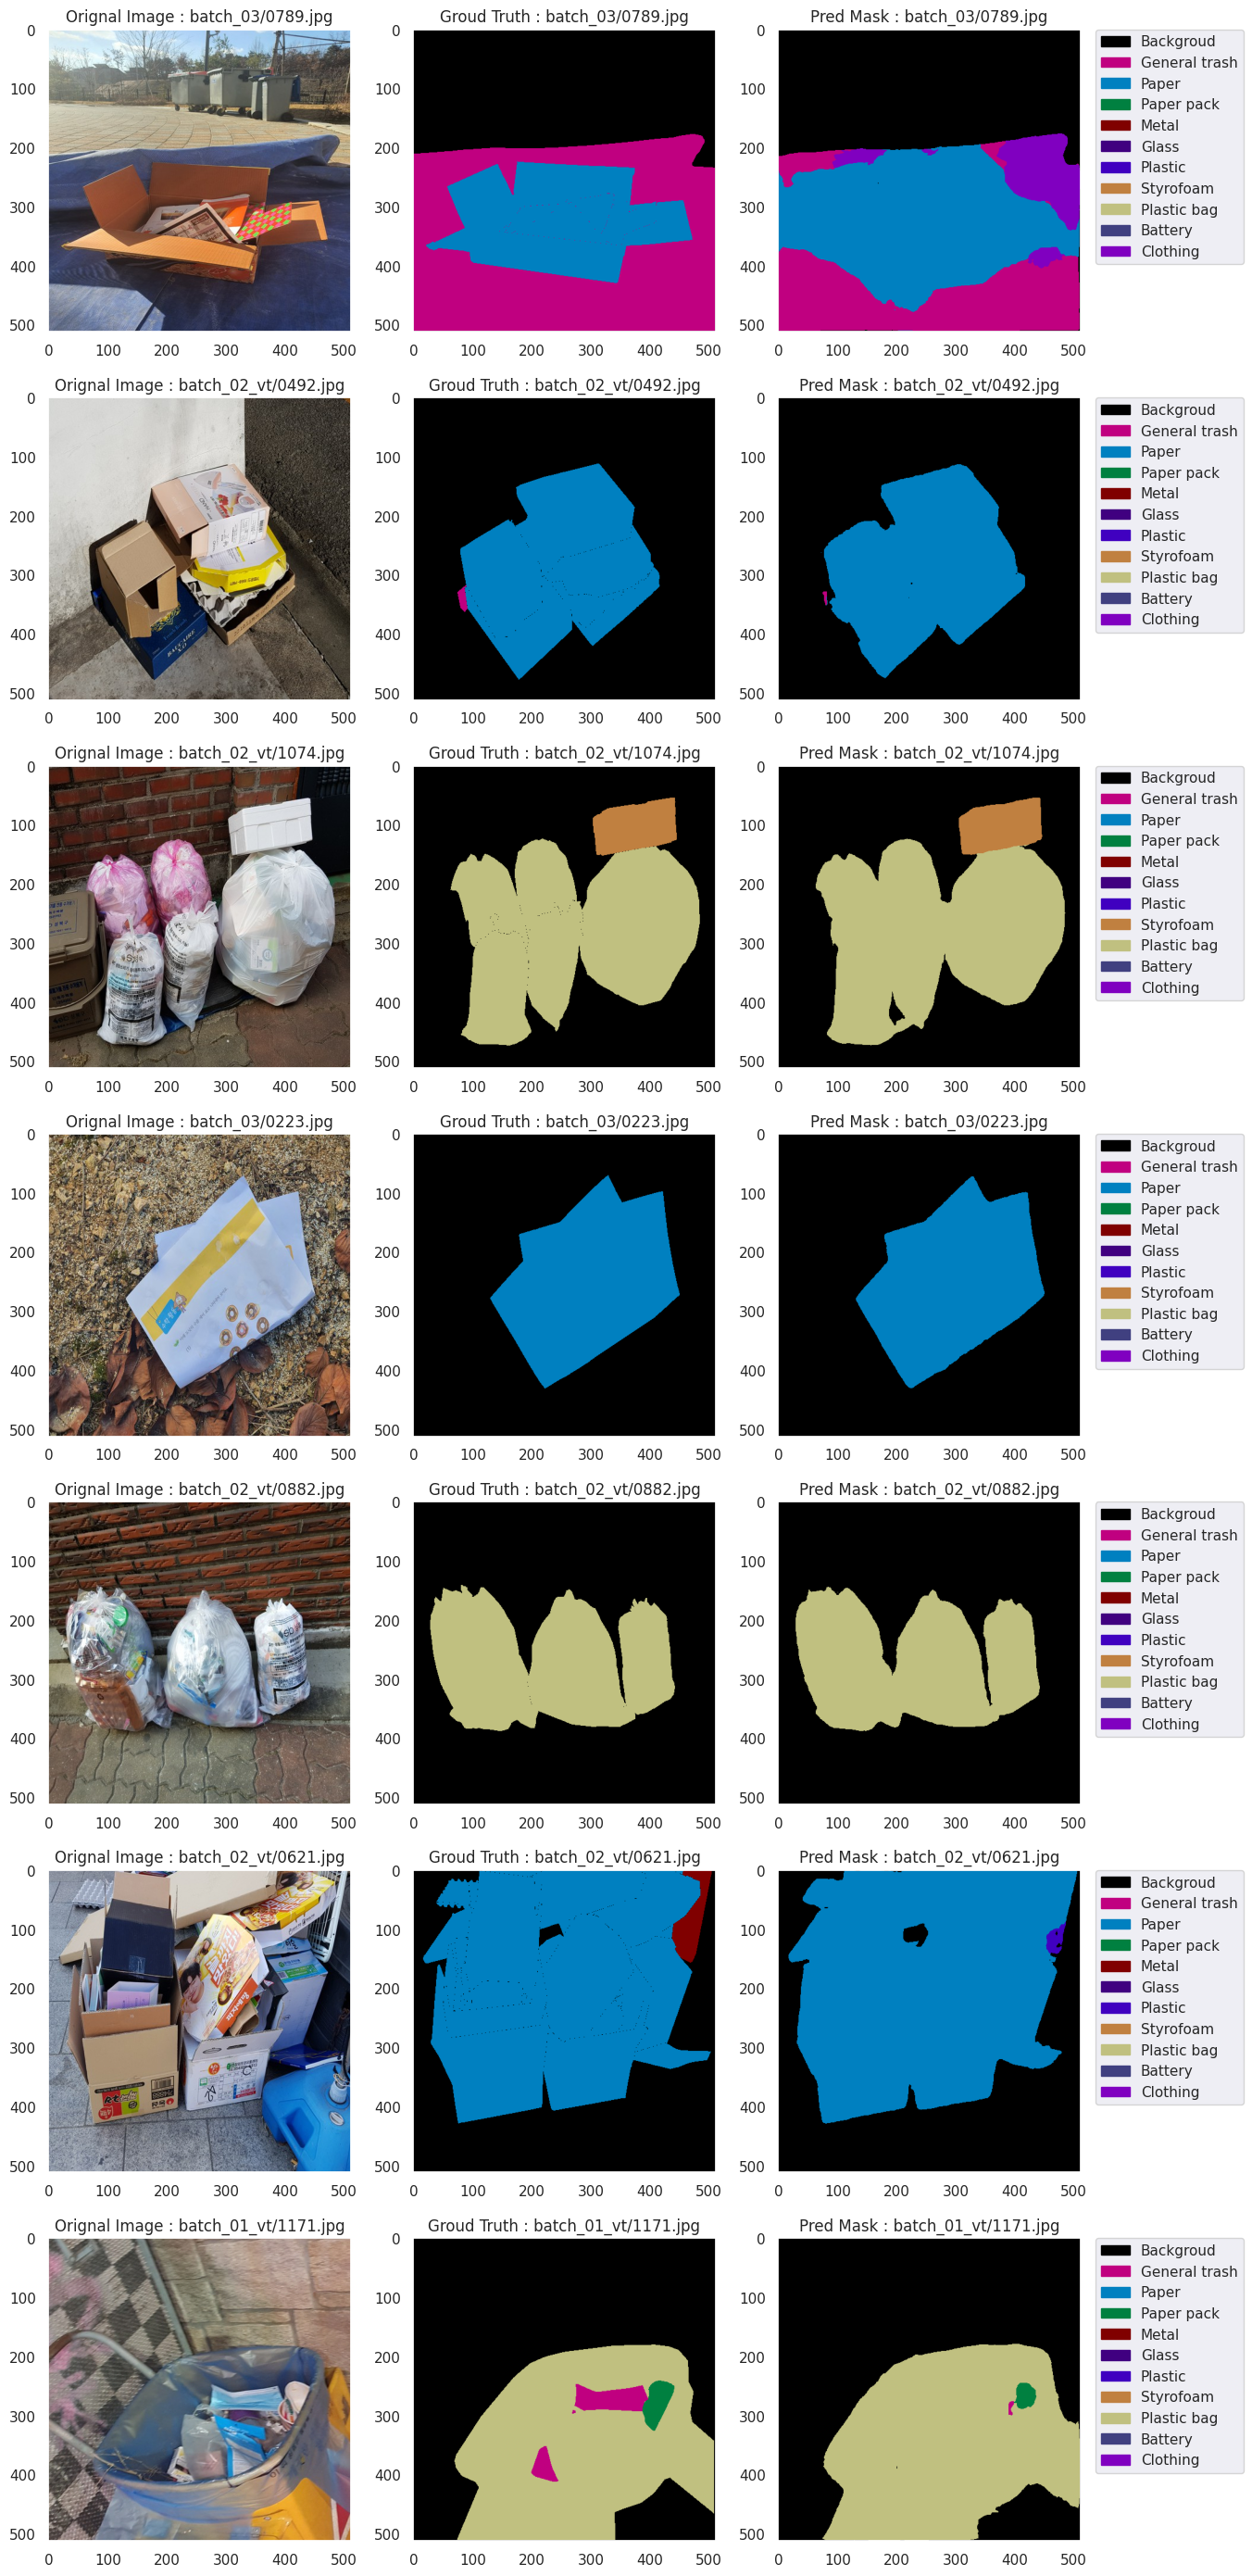

In [37]:
plot_examples(mode="train", batch_id=7, num_examples=batch_size, dataloaer=train_loader)

#### validation set 시각화

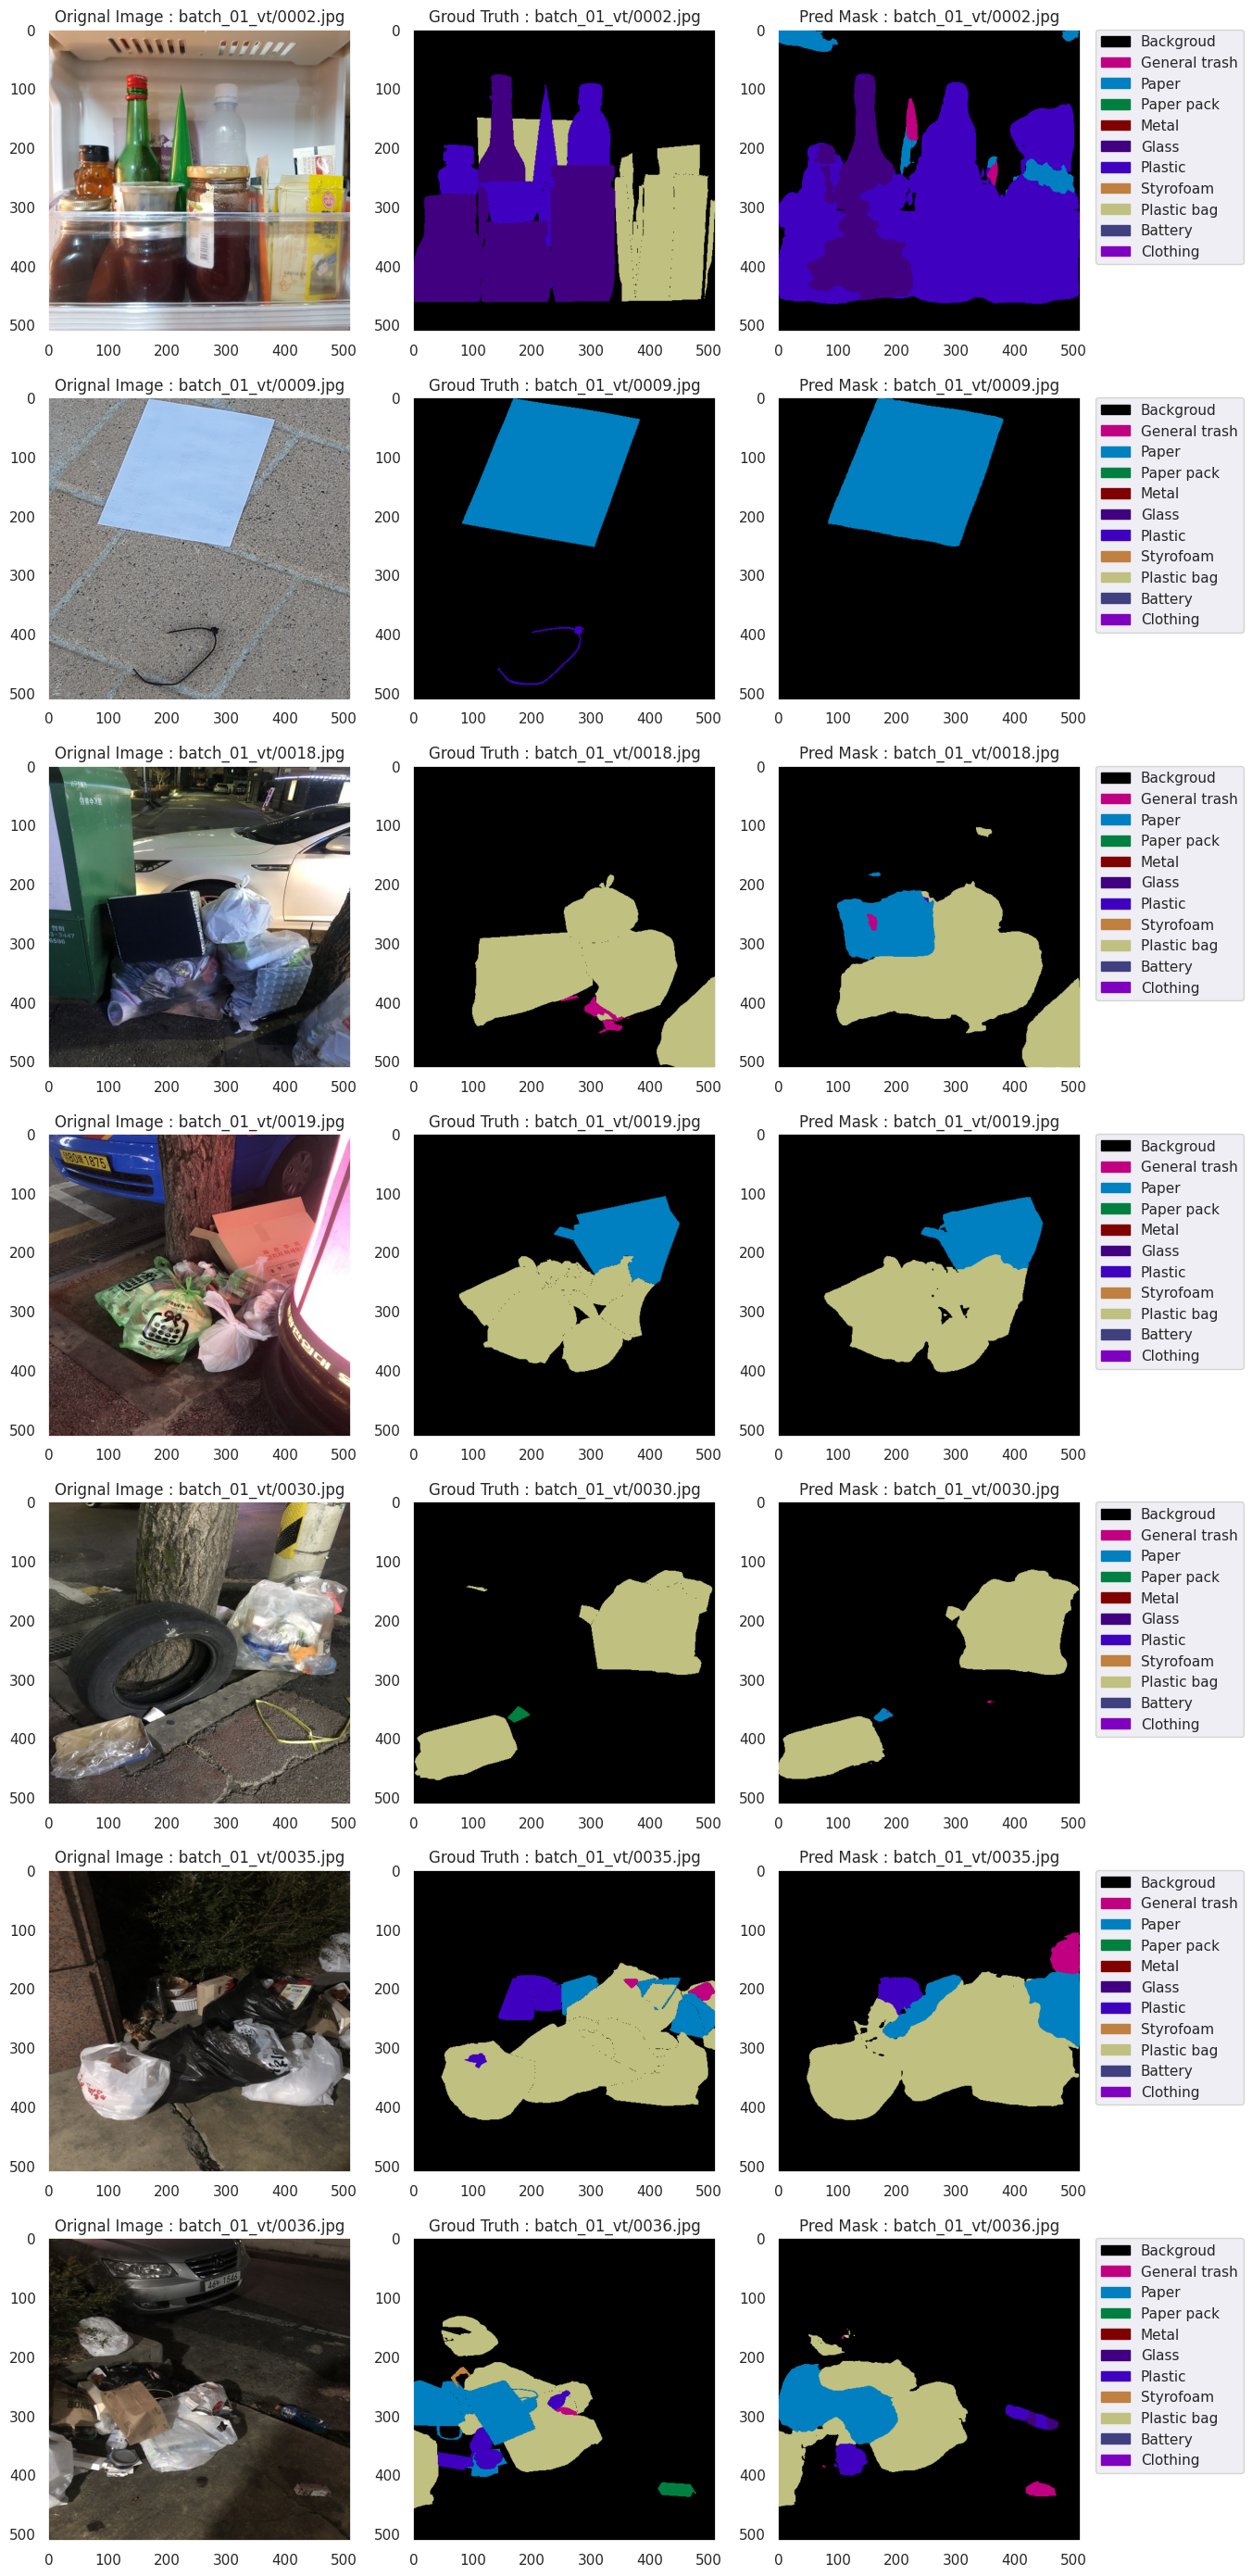

In [38]:
plot_examples(mode="val", batch_id=0, num_examples=batch_size, dataloaer=val_loader)

#### test set 시각화

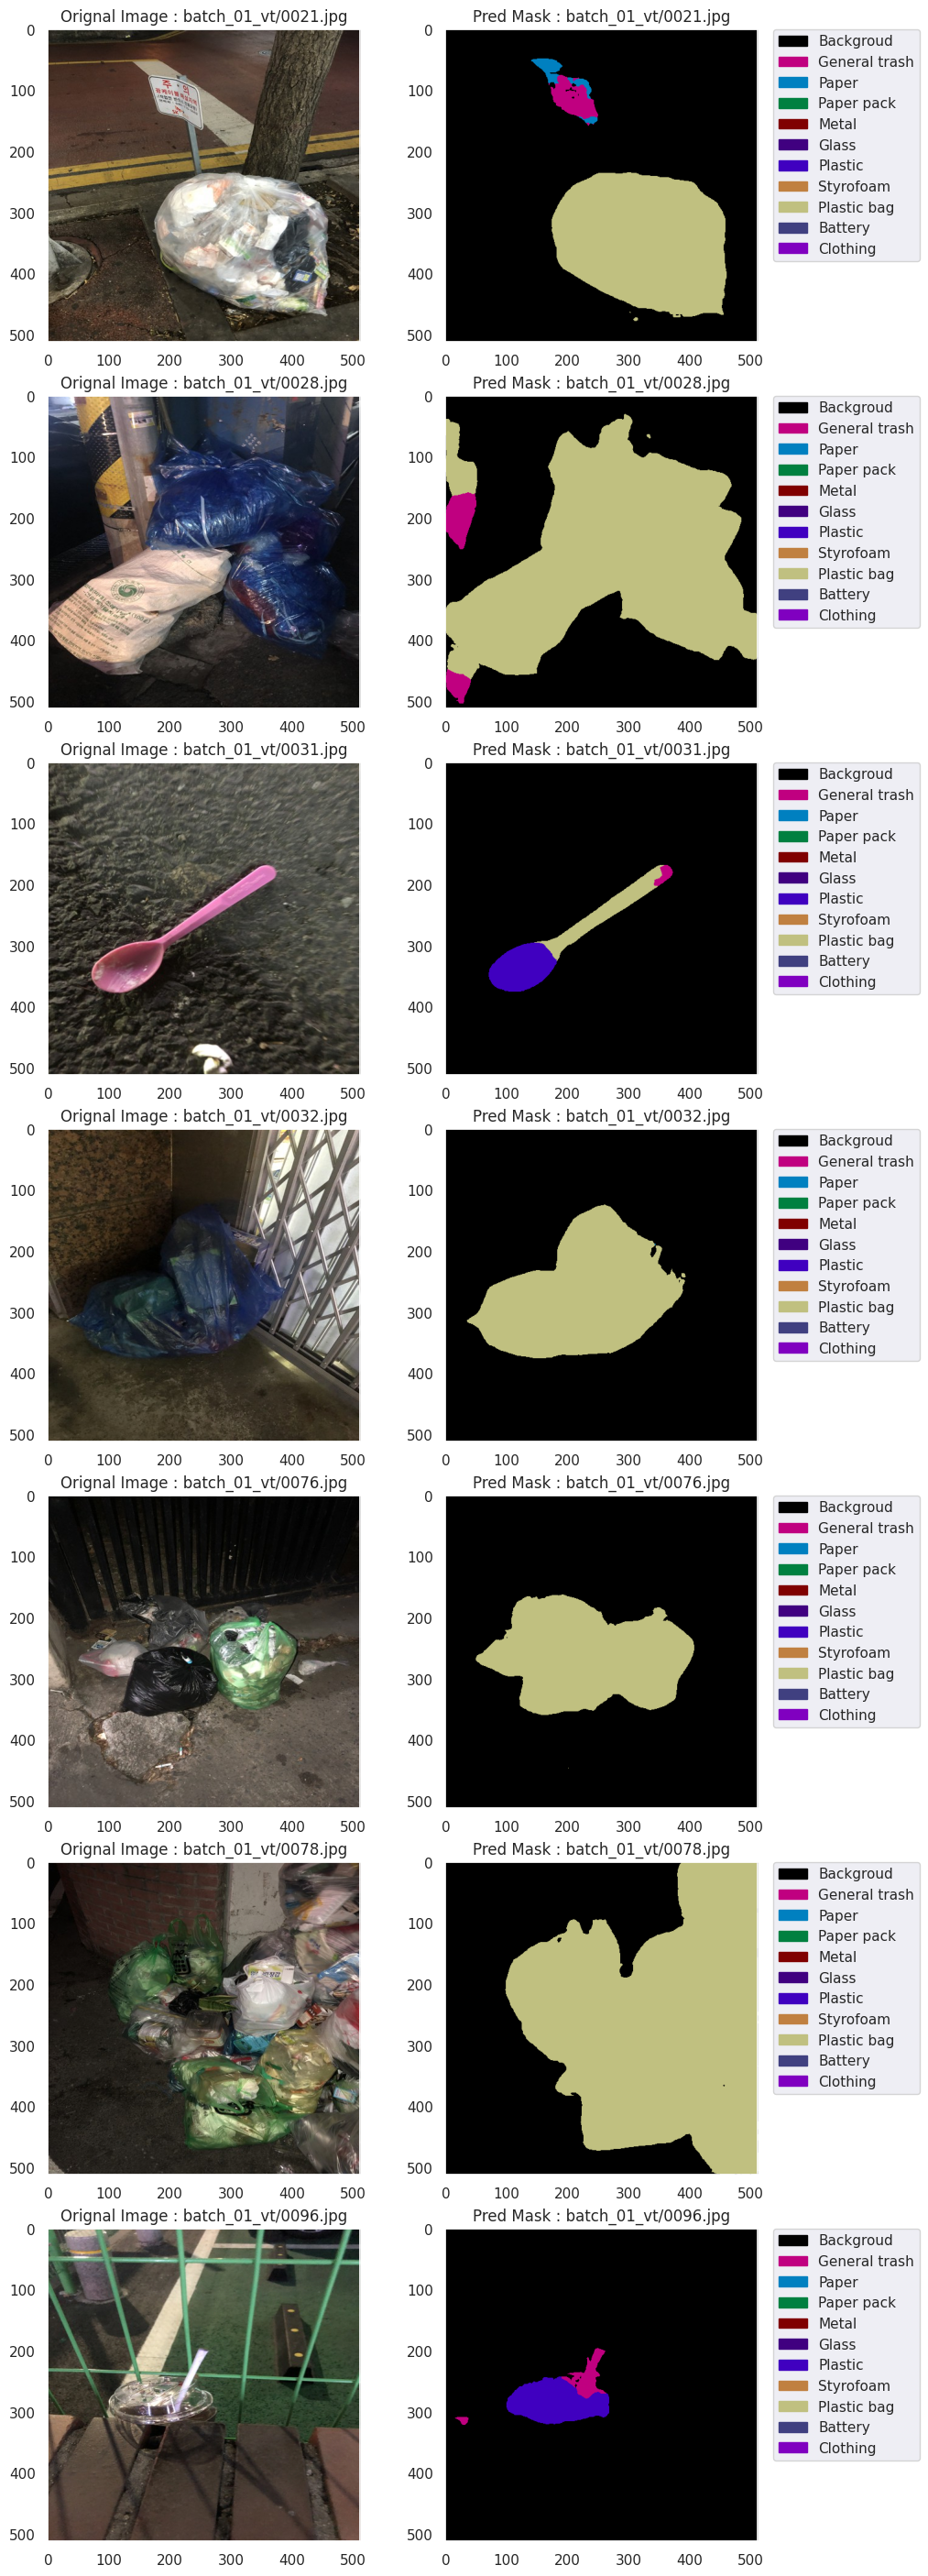

In [39]:
plot_examples(mode="test", batch_id=0, num_examples=batch_size, dataloaer=test_loader)

## submission을 위한 test 함수 정의

In [21]:
def test(model, data_loader, device):
    size = 256
    transform = A.Compose([A.Resize(size, size)])
    print('Start prediction.')
    
    model.eval()
    
    file_name_list = []
    preds_array = np.empty((0, size*size), dtype=np.long)
    
    with torch.no_grad():
        for step, (imgs, image_infos) in enumerate(tqdm(test_loader)):
            
            # inference (512 x 512)
            outs = model(torch.stack(imgs).to(device))
            oms = torch.argmax(outs.squeeze(), dim=1).detach().cpu().numpy()
            
            # resize (256 x 256)
            temp_mask = []
            for img, mask in zip(np.stack(imgs), oms):
                transformed = transform(image=img, mask=mask)
                mask = transformed['mask']
                temp_mask.append(mask)
                
            oms = np.array(temp_mask)
            
            oms = oms.reshape([oms.shape[0], size*size]).astype(int)
            preds_array = np.vstack((preds_array, oms))
            
            file_name_list.append([i['file_name'] for i in image_infos])
    print("End prediction.")
    file_names = [y for x in file_name_list for y in x]
    
    return file_names, preds_array

## submission.csv 생성

In [41]:
# sample_submisson.csv 열기
submission = pd.read_csv('./submission/sample_submission.csv', index_col=None)

# test set에 대한 prediction
file_names, preds = test(model, test_loader, device)

# PredictionString 대입
for file_name, string in zip(file_names, preds):
    submission = submission.append({"image_id" : file_name, "PredictionString" : ' '.join(str(e) for e in string.tolist())}, 
                                   ignore_index=True)

# submission.csv로 저장
submission.to_csv("./submission/efficient_unet_best_model.csv", index=False)

  0%|          | 0/117 [00:00<?, ?it/s]

Start prediction.


100%|██████████| 117/117 [05:58<00:00,  3.06s/it]


End prediction.
